INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:== Attack 구간 평균 지표 ==
INFO:__main__:motif1: 4.175800711743772
INFO:__main__:density: 0.2148169920233977
INFO:__main__:clustering: 0.21016174315996375
INFO:__main__:network_entropy: 1.193145829140268
INFO:__main__:edge_removal_resilience: 0.9227021278444767
INFO:__main__:== Non-Attack 구간 평균 지표 ==
INFO:__main__:motif1: 3.515813042261405
INFO:__main__:density: 0.21991002125343015
INFO:__main__:clustering: 0.17584645252851241
INFO:__main__:network_entropy: 1.0942778239192497
INFO:__main__:edge_removal_resilience: 0.9034142661766507


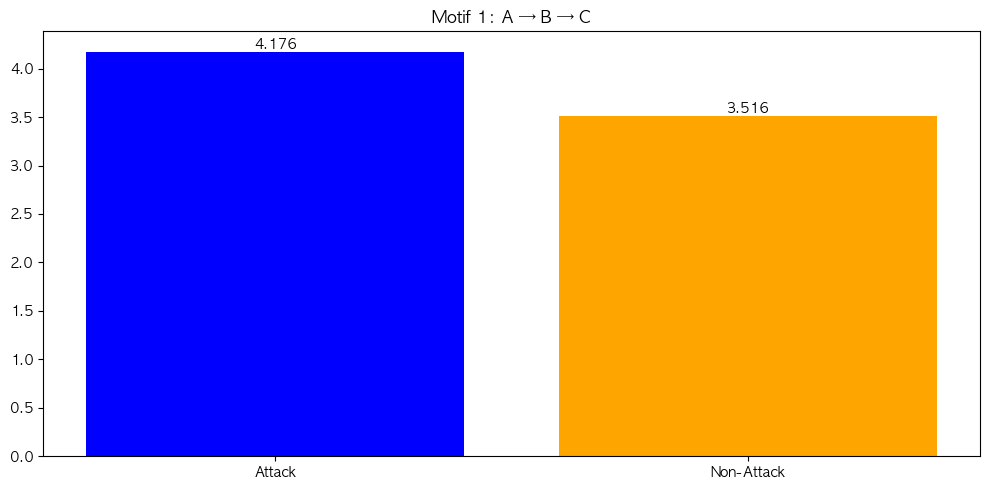

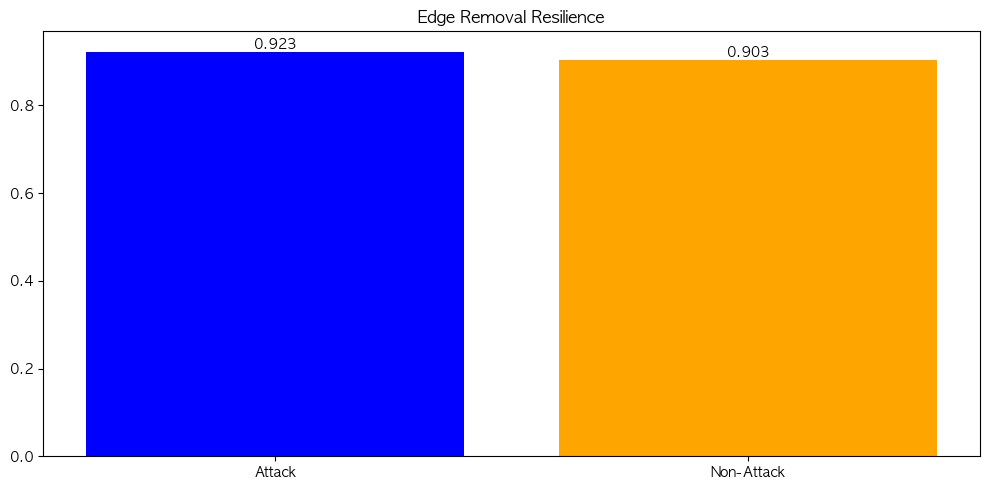

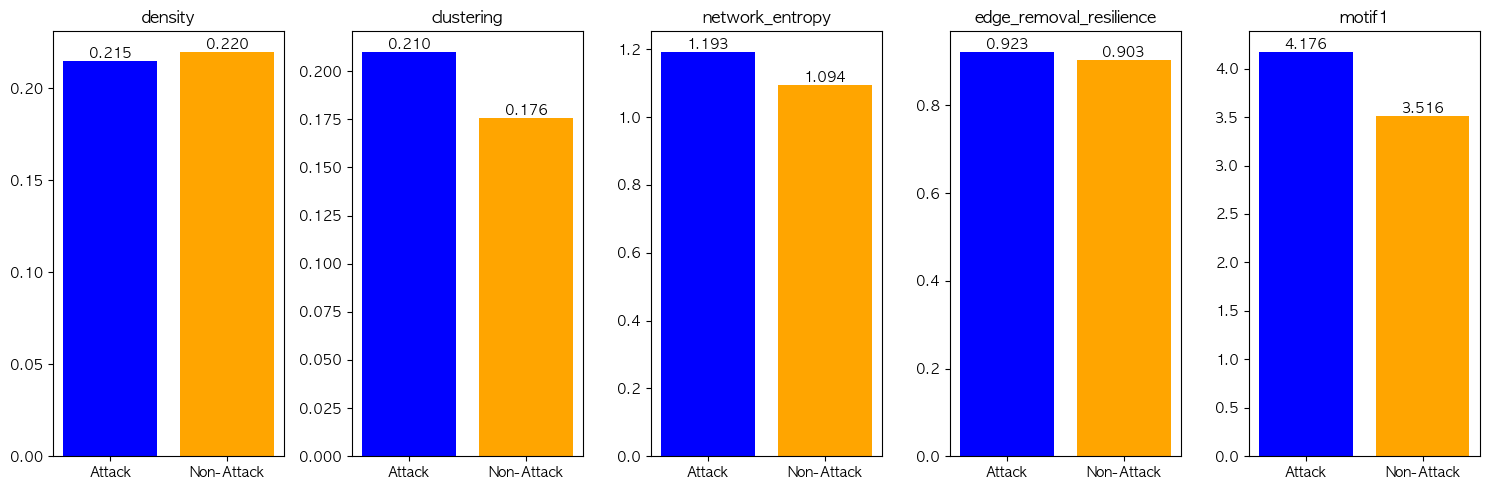

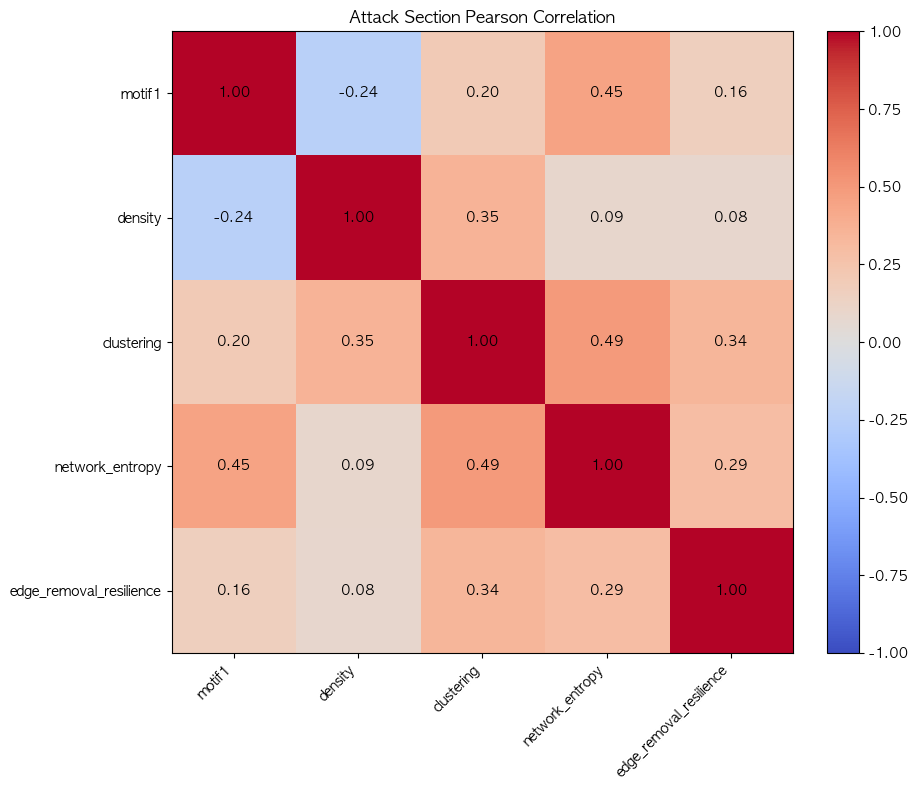

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import networkx as nx
import re
import itertools
import math
from collections import Counter
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
    return df

def preprocess_data(df):
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    frame_diff = end_frame_val - start_frame_val
    time_diff = end_time_sec - start_time_sec
    conversion_factor = frame_diff / time_diff
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
              for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    """모티프 정의 (Directed Graph) - 모티프 2 제거"""
    motifs = []
    
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    
    
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    undirected_G = G.to_undirected()
    return nx.average_clustering(undirected_G) if len(undirected_G) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or len(G.edges()) == 0:
        return 0
    
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    
    if len(G_removed.edges()) == 0:
        return 0
    
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],  
        "density": [],
        "clustering": [],
        "network_entropy": [],
        "edge_removal_resilience": []  
    }
    
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
            
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:  
            continue
            
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        
        density = compute_density(G)
        metrics["density"].append(density)
        
        clustering = compute_clustering(G)
        metrics["clustering"].append(clustering)
        
        net_entropy = degree_entropy(G)
        metrics["network_entropy"].append(net_entropy)
        
        edge_resilience = compute_edge_removal_resilience(G)
        metrics["edge_removal_resilience"].append(edge_resilience)
    return metrics

def get_attack_intervals(game_df, window=180):  
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):  
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def main():
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'
    
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)
    
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)
    attack_metrics_total = {
        key: [] for key in ["motif1", "density", "clustering", 
                           "network_entropy", "edge_removal_resilience"]  
    }
    nonattack_metrics_total = {
        key: [] for key in ["motif1", "density", "clustering", 
                           "network_entropy", "edge_removal_resilience"]  
    }
    
    for game_key, game_df in games:
        game_df = game_df.sort_values("unified_time_sec")
        attack_intervals = get_attack_intervals(game_df, window=180)  
        nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)  
        
        att_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
        nonatt_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
        
        for key in attack_metrics_total:
            attack_metrics_total[key].extend(att_metrics.get(key, []))
            nonattack_metrics_total[key].extend(nonatt_metrics.get(key, []))
    
    def safe_mean(lst):
        return np.mean(lst) if lst else None
    
    attack_avg_metrics = { k: safe_mean(v) for k, v in attack_metrics_total.items() }
    nonattack_avg_metrics = { k: safe_mean(v) for k, v in nonattack_metrics_total.items() }
    
    logger.info("== Attack 구간 평균 지표 ==")
    for key, value in attack_avg_metrics.items():
        logger.info(f"{key}: {value}")
    
    logger.info("== Non-Attack 구간 평균 지표 ==")
    for key, value in nonattack_avg_metrics.items():
        logger.info(f"{key}: {value}")
    
    all_metrics = ["motif1", "density", "clustering", 
                  "network_entropy", "edge_removal_resilience"]  
    
    plt.figure(figsize=(10, 5))
    vals = [attack_avg_metrics["motif1"], nonattack_avg_metrics["motif1"]]
    plt.bar(['Attack', 'Non-Attack'], vals, color=['blue', 'orange'])
    plt.title("Motif 1: A → B → C")
    for j, val in enumerate(vals):
        plt.text(j, val, f"{val:.3f}" if val is not None else "N/A", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig('motif1_comparison.png')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    vals = [attack_avg_metrics["edge_removal_resilience"], nonattack_avg_metrics["edge_removal_resilience"]]
    plt.bar(['Attack', 'Non-Attack'], vals, color=['blue', 'orange'])
    plt.title("Edge Removal Resilience")
    for j, val in enumerate(vals):
        plt.text(j, val, f"{val:.3f}" if val is not None else "N/A", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig('new_metrics_comparison.png')
    plt.show()
    
    plt.figure(figsize=(15, 5))
    other_metrics = ["density", "clustering", "network_entropy", "edge_removal_resilience", "motif1"]
    for i, metric in enumerate(other_metrics):
        plt.subplot(1, 5, i+1)
        vals = [attack_avg_metrics[metric], nonattack_avg_metrics[metric]]
        plt.bar(['Attack', 'Non-Attack'], vals, color=['blue', 'orange'])
        plt.title(metric)
        for j, val in enumerate(vals):
            plt.text(j, val, f"{val:.3f}" if val is not None else "N/A", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig('network_metrics_comparison.png')
    plt.show()
    
    attack_df_metrics = pd.DataFrame(attack_metrics_total)
    corr_matrix = np.array(attack_df_metrics.corr(method='pearson'))
    labels = all_metrics
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title("Attack Section Pearson Correlation")
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f"{corr_matrix[i, j]:.2f}", ha="center", va="center", color="black", fontsize=10)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

if __name__ == "__main__":
    main()

INFO:__main__:Loaded data with shape: (389139, 16)
/var/folders/36/p8zhvqnx5ldbrfz0w3dy4mzm0000gn/T/ipykernel_80740/3646388265.py:268: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors,
/var/folders/36/p8zhvqnx5ldbrfz0w3dy4mzm0000gn/T/ipykernel_80740/3646388265.py:302: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors,


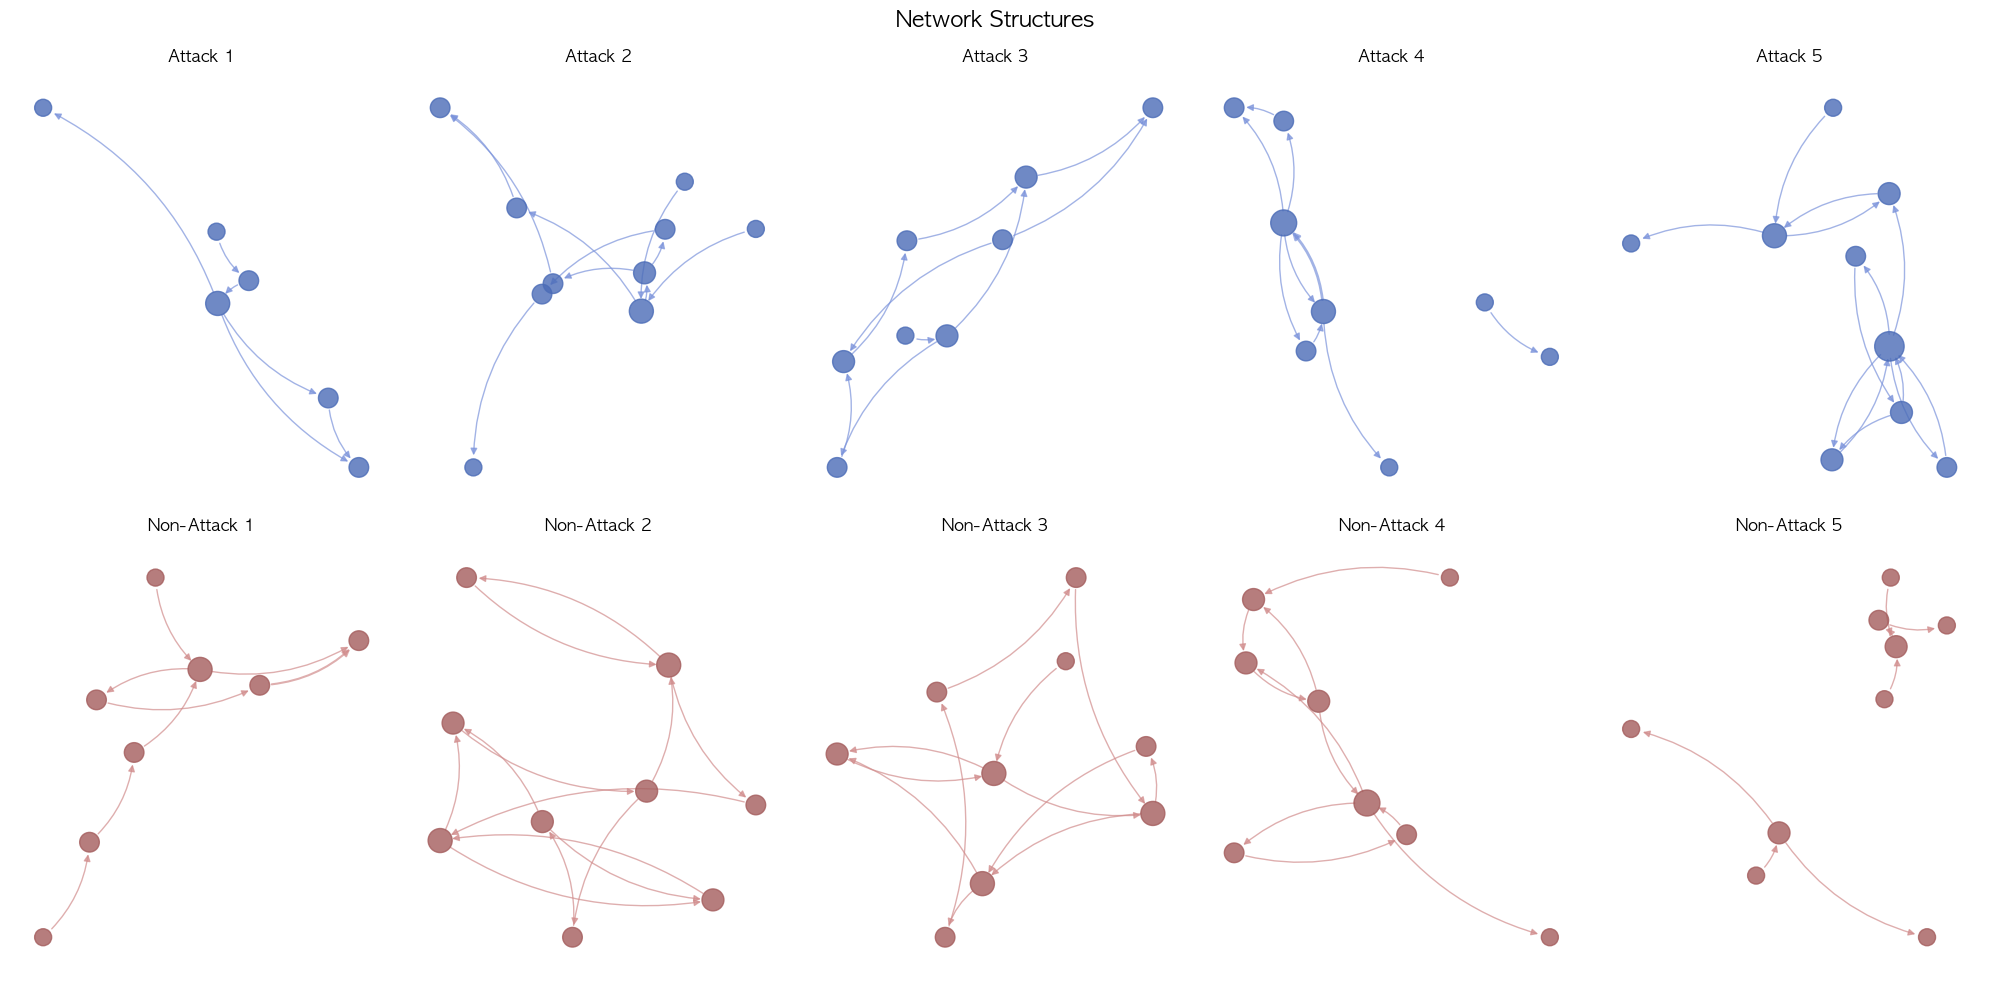

INFO:__main__:Visualization complete and saved as 'soccer_network_comparison.png'


In [11]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import networkx as nx
import re
import itertools
import math
from collections import Counter
import logging
from matplotlib.colors import LinearSegmentedColormap

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
    return df

def preprocess_data(df):
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    frame_diff = end_frame_val - start_frame_val
    time_diff = end_time_sec - start_time_sec
    conversion_factor = frame_diff / time_diff
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
              for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G
def define_motifs():
    motifs = []
    
    # Motif 1: A → B → C
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    
    # Motif 2: A ↔ B → C
    g2 = nx.DiGraph()
    g2.add_edges_from([(0, 1), (1, 0), (1, 2)])
    motifs.append(g2)
    
    return motifs

def is_isomorphic(G1, G2):
    """동형성 비교: 두 그래프의 방향 인접 행렬 비교"""
    # G1: motif, G2: subgraph
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    """모티프 패턴 카운팅"""
    motifs = define_motifs()
    counts = [0] * len(motifs)
    
    # 3-노드 조합 검사
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    
    return counts

def compute_density(G):
    """네트워크 밀도 계산"""
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    """클러스터링 계수 계산"""
    undirected_G = G.to_undirected()
    return nx.average_clustering(undirected_G) if len(undirected_G) > 0 else 0

def degree_entropy(G):
    """노드 차수 기반 엔트로피 계산"""
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def visualize_network_samples(file_path, sheet_name):
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)
    
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)
    game_key, game_df = next(iter(games))
    
    attack_intervals = get_attack_intervals(game_df, window=180)
    nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
    
    selected_attack = attack_intervals[:5] if len(attack_intervals) >= 5 else attack_intervals
    selected_nonattack = nonattack_intervals[:5] if len(nonattack_intervals) >= 5 else nonattack_intervals
    
    plt.figure(figsize=(20, 10))
    
    attack_colors = ['#4B6CB7', '#7B93DB']  
    nonattack_colors = ['#A45D5D', '#D18C8C']  
    
    for i, interval in enumerate(selected_attack):
        segment_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & (game_df["unified_time_sec"] <= interval[1])]
        
        G = build_pass_network(segment_df)
        
        motif_counts = count_motifs(G) if len(G.nodes()) > 2 else [0, 0]
        clustering = compute_clustering(G)
        density = compute_density(G)
        entropy = degree_entropy(G)
        
        plt.subplot(2, 5, i+1)
        
        node_sizes = [100 + 50 * G.degree(n) for n in G.nodes()]
        node_colors = [attack_colors[0]] * len(G.nodes())
        
        edge_weights = [0.5 + 0.5 * G[u][v].get('weight', 1) for u, v in G.edges()]
        edge_colors = [attack_colors[1]] * len(G.edges())
        
        pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)
        
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, 
                              arrowsize=10, alpha=0.7, 
                              connectionstyle='arc3, rad=0.2')
        
        
        plt.title(f"Attack {i+1}")
        plt.axis('off')
    
    for i, interval in enumerate(selected_nonattack):
        segment_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & (game_df["unified_time_sec"] <= interval[1])]
        G = build_pass_network(segment_df)
        
        motif_counts = count_motifs(G) if len(G.nodes()) > 2 else [0, 0]
        clustering = compute_clustering(G)
        density = compute_density(G)
        entropy = degree_entropy(G)
        
        plt.subplot(2, 5, i+6)  
        node_sizes = [100 + 50 * G.degree(n) for n in G.nodes()]
        node_colors = [nonattack_colors[0]] * len(G.nodes())
        
        edge_weights = [0.5 + 0.5 * G[u][v].get('weight', 1) for u, v in G.edges()]
        edge_colors = [nonattack_colors[1]] * len(G.edges())
        
        pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)
        
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, 
                              arrowsize=10, alpha=0.7,
                              connectionstyle='arc3, rad=0.2')
        
        
        plt.title(f"Non-Attack {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Network Structures", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.savefig("soccer_network_comparison.png", dpi=900, bbox_inches='tight')
    plt.show()
    
    return "Visualization complete and saved as 'soccer_network_comparison.png'"

def main():
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'
    
    # 네트워크 시각화 실행
    result = visualize_network_samples(file_path, sheet_name)
    logger.info(result)

if __name__ == "__main__":
    main()

In [12]:
import pandas as pd
import numpy as np

def count_games_by_era(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
    
    df['연도'] = df['경기일'].astype(str).str[:4].astype(int)
    
    df['시대'] = pd.cut(df['연도'], 
                      bins=[1900, 2000, 2010, 2025],  
                      labels=['1900년대', '2000~2010년', '2010년 이후'])
    
    unique_games = df.drop_duplicates(subset=["경기일", "홈팀명", "상대팀명"])
    
    era_counts = unique_games['시대'].value_counts().sort_index()
    
    total_games = len(unique_games)
    
    print(f"총 경기 수: {total_games}")
    print("\n시대별 경기 수:")
    for era, count in era_counts.items():
        print(f"{era}: {count}경기 ({count/total_games*100:.1f}%)")
    
    return era_counts

file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
sheet_name = '대표팀(~10)'  
era_counts = count_games_by_era(file_path, sheet_name)

총 경기 수: 302

시대별 경기 수:
1900년대: 70경기 (23.2%)
2000~2010년: 146경기 (48.3%)
2010년 이후: 86경기 (28.5%)


INFO:__main__:결과 파일이 era_analysis_results 폴더에 저장됩니다.
INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:After filtering women's team, data shape: (338415, 16)
/var/folders/36/p8zhvqnx5ldbrfz0w3dy4mzm0000gn/T/ipykernel_80740/306894267.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  era_stats = pd.concat([era_stats, pd.DataFrame([new_row])], ignore_index=True)
/var/folders/36/p8zhvqnx5ldbrfz0w3dy4mzm0000gn/T/ipykernel_80740/306894267.py:408: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat ope


motif1 (비공격) - Tukey HSD 사후 검정 결과:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
    1900년대 2000~2010년   0.0451 0.9415 -0.2747 0.3649  False
    1900년대   2010년 이후   0.3978 0.0182  0.0544 0.7411   True
2000~2010년   2010년 이후   0.3526 0.0092  0.0718 0.6335   True
-----------------------------------------------------------

density (공격) - Tukey HSD 사후 검정 결과:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
    1900년대 2000~2010년   0.0028 0.7052 -0.0054 0.0111  False
    1900년대   2010년 이후   0.0109 0.0166  0.0016 0.0202   True
2000~2010년   2010년 이후   0.0081 0.0472  0.0001 0.0161   True
-----------------------------------------------------------

density (비공격) - Tukey HSD 사후 검정 결과:
    Multiple Comparison of Means - Tukey HSD, FWER=

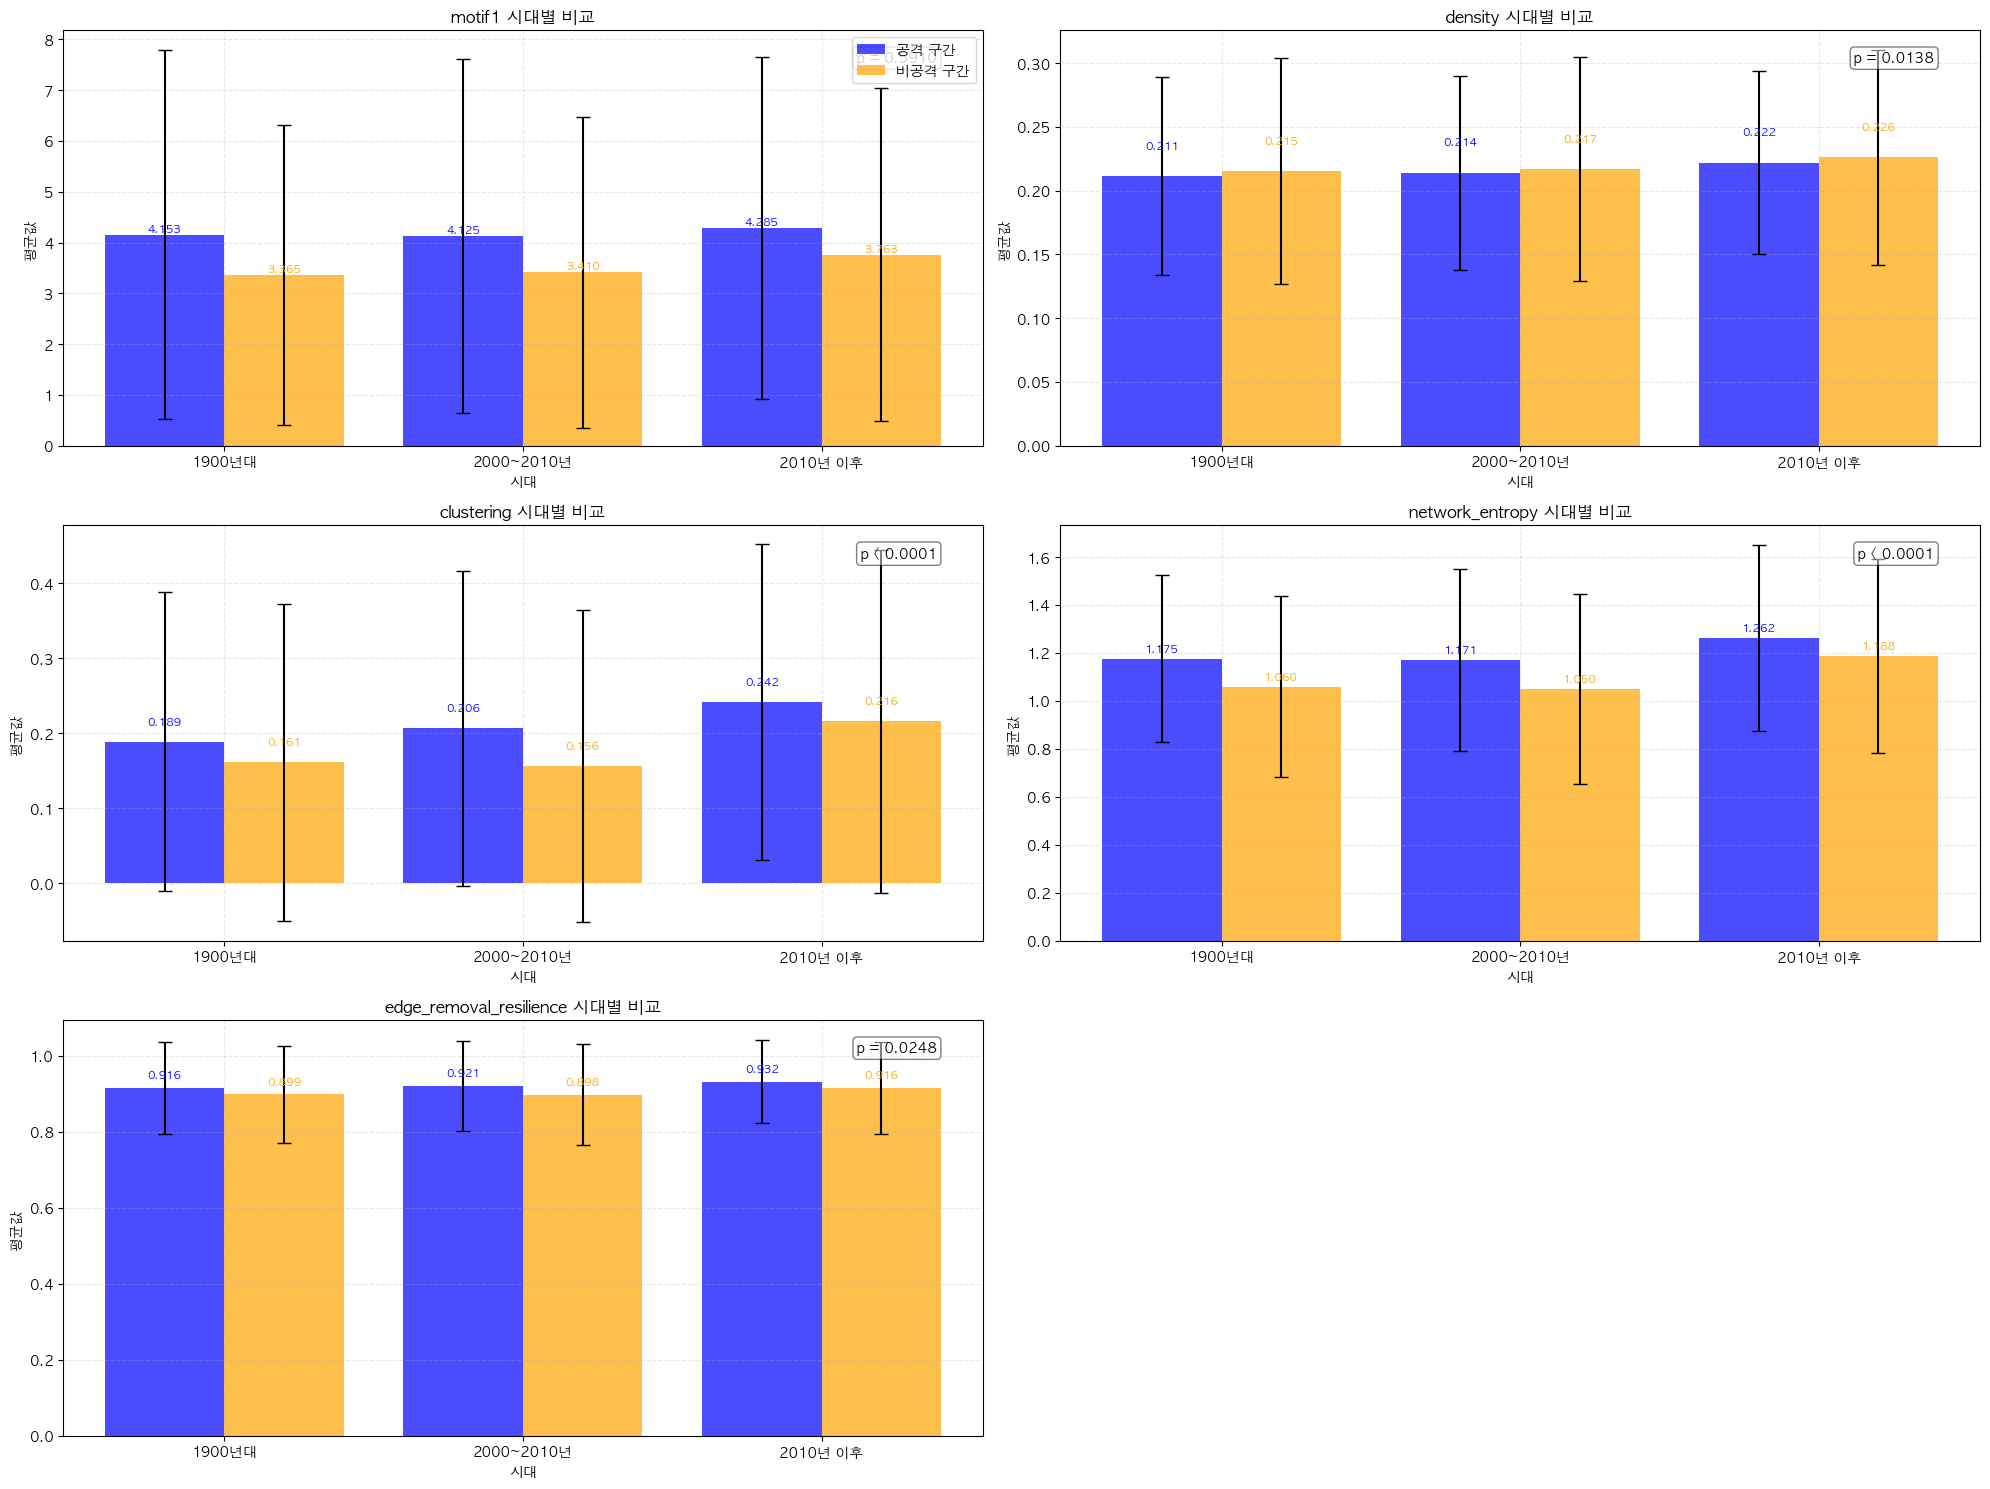

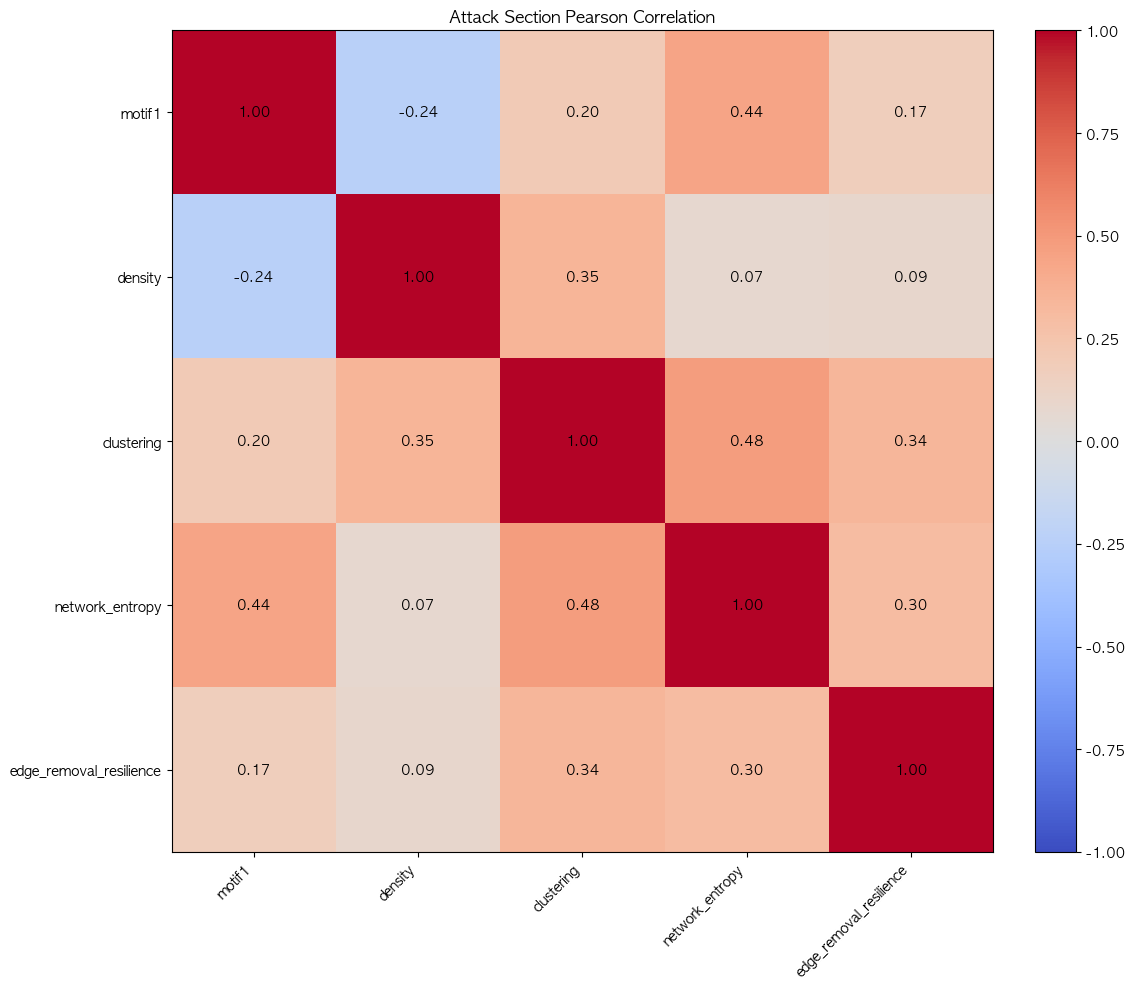

시대별 네트워크 지표 통계가 'era_analysis_results/era_network_metrics_stats.csv'로 저장되었습니다.
ANOVA 검정 결과가 'era_analysis_results/era_network_metrics_anova.csv'로 저장되었습니다.


In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import logging
import networkx as nx
from collections import Counter
import math
import itertools
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

OUTPUT_DIR = "era_analysis_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
logger.info(f"결과 파일이 {OUTPUT_DIR} 폴더에 저장됩니다.")

def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info(f"Loaded data with shape: {df.shape}")
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
        logger.info(f"After filtering women's team, data shape: {df.shape}")
    else:
        available_columns = df.columns.tolist()
        logger.warning(f"'홈팀명' 열이 존재하지 않습니다. 사용 가능한 열: {available_columns}")
        raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
    return df

def preprocess_data(df):
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    frame_diff = end_frame_val - start_frame_val
    time_diff = end_time_sec - start_time_sec
    conversion_factor = frame_diff / time_diff
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
              for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    
    # Motif 1: A → B → C
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    undirected_G = G.to_undirected()
    return nx.average_clustering(undirected_G) if len(undirected_G) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

# 추가된 네트워크 지표 계산 함수
def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or len(G.edges()) == 0:
        return 0
    
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    
    if len(G_removed.edges()) == 0:
        return 0
    
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],
        "density": [],
        "clustering": [],
        "network_entropy": [],
        "edge_removal_resilience": []  
    }
    
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
            
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:  
            continue
            
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        
        density = compute_density(G)
        metrics["density"].append(density)
        
        clustering = compute_clustering(G)
        metrics["clustering"].append(clustering)
        
        net_entropy = degree_entropy(G)
        metrics["network_entropy"].append(net_entropy)
        
        edge_resilience = compute_edge_removal_resilience(G)
        metrics["edge_removal_resilience"].append(edge_resilience)
        
    return metrics

def analyze_era_metrics(file_path, sheet_name):
    # 1. 데이터 로드 및 전처리
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)
    
    # 연도 추출 및 시대 그룹화
    df_sheet['연도'] = df_sheet['경기일'].astype(str).str[:4].astype(int)
    df_sheet['시대'] = pd.cut(df_sheet['연도'], 
                          bins=[1900, 2000, 2010, 2025],
                          labels=['1900년대', '2000~2010년', '2010년 이후'])
    
    # 2. 결과 저장을 위한 데이터프레임 초기화
    metrics = ["motif1", "density", "clustering", "network_entropy", 
              "edge_removal_resilience"]  
    era_stats = pd.DataFrame(columns=['시대', '지표', '구간유형', '평균', '표준편차', '표본수'])
    anova_results = pd.DataFrame(columns=['지표', '구간유형', 'F통계량', 'p값', '유의성'])
    
    # 3. 각 게임별로 공격/비공격 구간 지표 계산
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)
    
    # 시대별, 경기별 지표를 수집할 리스트
    all_game_metrics = []
    
    for game_key, game_df in games:
        # 게임 정보 및 시대 정보
        game_date, home_team, away_team = game_key
        era = game_df['시대'].iloc[0]  
        
        # 공격/비공격 구간 식별
        attack_intervals = get_attack_intervals(game_df, window=180)
        nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
        
        # 공격 구간 지표 계산
        attack_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
        
        # 각 공격 구간 지표를 데이터프레임으로 변환하여 저장
        for i in range(len(attack_metrics.get('motif1', []))):
            metrics_row = {'경기일': game_date, '홈팀명': home_team, '상대팀명': away_team,
                          '시대': era, '구간유형': '공격'}
            for metric in metrics:
                if i < len(attack_metrics.get(metric, [])):
                    metrics_row[metric] = attack_metrics[metric][i]
                else:
                    metrics_row[metric] = np.nan
            all_game_metrics.append(metrics_row)
        
        # 비공격 구간 지표 계산
        nonattack_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
        
        # 각 비공격 구간 지표를 데이터프레임으로 변환하여 저장
        for i in range(len(nonattack_metrics.get('motif1', []))):
            metrics_row = {'경기일': game_date, '홈팀명': home_team, '상대팀명': away_team,
                          '시대': era, '구간유형': '비공격'}
            for metric in metrics:
                if i < len(nonattack_metrics.get(metric, [])):
                    metrics_row[metric] = nonattack_metrics[metric][i]
                else:
                    metrics_row[metric] = np.nan
            all_game_metrics.append(metrics_row)
    
    # 수집된 모든 지표를 데이터프레임으로 변환
    metrics_df = pd.DataFrame(all_game_metrics)
    
    # 4. 시대별, 구간별 지표의 평균과 표준편차 계산
    for metric in metrics:
        for section_type in ['공격', '비공격']:
            section_data = metrics_df[metrics_df['구간유형'] == section_type]
            
            # 각 시대별 통계 계산
            for era in ['1900년대', '2000~2010년', '2010년 이후']:
                era_data = section_data[section_data['시대'] == era][metric].dropna()
                
                if len(era_data) > 0:
                    mean_val = era_data.mean()
                    std_val = era_data.std()
                    count = len(era_data)
                    
                    # 결과 저장
                    new_row = {
                        '시대': era,
                        '지표': metric,
                        '구간유형': section_type,
                        '평균': mean_val,
                        '표준편차': std_val,
                        '표본수': count
                    }
                    era_stats = pd.concat([era_stats, pd.DataFrame([new_row])], ignore_index=True)
    
    # 5. ANOVA 검정: 시대별로 지표 차이가 있는지 검정
    for metric in metrics:
        for section_type in ['공격', '비공격']:
            # 해당 지표와 구간 유형에 맞는 데이터 추출
            test_data = []
            test_groups = []
            
            for era in ['1900년대', '2000~2010년', '2010년 이후']:
                era_data = metrics_df[(metrics_df['시대'] == era) & 
                                   (metrics_df['구간유형'] == section_type)][metric].dropna()
                
                if len(era_data) > 0:
                    test_data.extend(era_data.values)
                    test_groups.extend([era] * len(era_data))
            
            # 충분한 데이터가 있을 경우에만 ANOVA 실행
            if len(set(test_groups)) >= 2:  # 최소 2개 이상의 그룹이 필요
                try:
                    f_val, p_val = stats.f_oneway(
                        *[metrics_df[(metrics_df['시대'] == era) & 
                                  (metrics_df['구간유형'] == section_type)][metric].dropna() 
                         for era in sorted(set(test_groups))])
                    
                    # 유의성 판단
                    significance = "유의함" if p_val < 0.05 else "유의하지 않음"
                    
                    # 결과 저장
                    new_row = {
                        '지표': metric,
                        '구간유형': section_type,
                        'F통계량': f_val,
                        'p값': p_val,
                        '유의성': significance
                    }
                    anova_results = pd.concat([anova_results, pd.DataFrame([new_row])], ignore_index=True)
                    
                    # ANOVA가 유의하면 사후 검정 수행
                    if p_val < 0.05:
                        # Tukey의 HSD 테스트
                        tukey = pairwise_tukeyhsd(np.array(test_data), np.array(test_groups), alpha=0.05)
                        print(f"\n{metric} ({section_type}) - Tukey HSD 사후 검정 결과:")
                        print(tukey)
                except Exception as e:
                    print(f"ANOVA 실행 중 오류 발생 ({metric}, {section_type}): {e}")
    
    # 6. 결과 출력
    print("\n시대별 네트워크 지표의 평균 및 표준편차:")
    print(era_stats)
    
    print("\nANOVA 검정 결과:")
    print(anova_results)
    
    # 7. 시각화: 시대별 지표 비교 (평균 ± 표준편차)
    plt.figure(figsize=(20, 15))
    
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        
        # 공격 구간 데이터
        attack_data = era_stats[(era_stats['지표'] == metric) & (era_stats['구간유형'] == '공격')]
        
        if not attack_data.empty:
            # 시대 순서대로 정렬
            attack_data = attack_data.sort_values(by='시대')
            x_pos = np.arange(len(attack_data))
            
            # 막대 그래프: 평균 및 오차 막대
            plt.bar(x_pos - 0.2, attack_data['평균'], yerr=attack_data['표준편차'], 
                    width=0.4, label='공격 구간', color='blue', capsize=5, alpha=0.7)
            
            # 비공격 구간 데이터
            nonattack_data = era_stats[(era_stats['지표'] == metric) & (era_stats['구간유형'] == '비공격')]
            
            if not nonattack_data.empty:
                # 시대 순서대로 정렬
                nonattack_data = nonattack_data.sort_values(by='시대')
                
                # 막대 그래프: 평균 및 오차 막대
                plt.bar(x_pos + 0.2, nonattack_data['평균'], yerr=nonattack_data['표준편차'], 
                        width=0.4, label='비공격 구간', color='orange', capsize=5, alpha=0.7)
            
            # 평균값 표시
            for j, row in attack_data.reset_index().iterrows():
                plt.text(j-0.2, row['평균']+0.02, f"{row['평균']:.3f}", 
                         ha='center', va='bottom', fontsize=8, color='blue')
            
            for j, row in nonattack_data.reset_index().iterrows():
                plt.text(j+0.2, row['평균']+0.02, f"{row['평균']:.3f}", 
                         ha='center', va='bottom', fontsize=8, color='orange')
            
            # 그래프 설정
            plt.title(f"{metric} 시대별 비교")
            plt.xticks(x_pos, attack_data['시대'])
            plt.xlabel('시대')
            plt.ylabel('평균값')
            
            # p값이 있으면 표시
            anova_result = anova_results[(anova_results['지표'] == metric) & (anova_results['구간유형'] == '공격')]
            if not anova_result.empty:
                p_val = anova_result.iloc[0]['p값']
                p_str = f"p = {p_val:.4f}" if p_val >= 0.0001 else "p < 0.0001"
                plt.text(0.95, 0.95, p_str, transform=plt.gca().transAxes, 
                         ha='right', va='top', fontsize=10,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
            
            plt.grid(True, linestyle='--', alpha=0.3)
            
            if i == 0:
                plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "era_metrics_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. 상관관계 히트맵 시각화
    # Attack 구간 지표 간 Pearson 상관계수 히트맵
    attack_df_metrics = metrics_df[metrics_df['구간유형'] == '공격'][metrics]
    corr_matrix = np.array(attack_df_metrics.corr(method='pearson'))
    labels = metrics
    
    plt.figure(figsize=(12, 10))
    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title("Attack Section Pearson Correlation")
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f"{corr_matrix[i, j]:.2f}", ha="center", va="center", color="black", fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'era_correlation_heatmap.png'))
    plt.show()
    
    # 시대별 네트워크 지표 통계 저장
    era_stats.to_csv(os.path.join(OUTPUT_DIR, "era_network_metrics_stats.csv"), index=False, encoding='utf-8-sig')
    print(f"시대별 네트워크 지표 통계가 '{OUTPUT_DIR}/era_network_metrics_stats.csv'로 저장되었습니다.")

    # ANOVA 검정 결과 저장
    anova_results.to_csv(os.path.join(OUTPUT_DIR, "era_network_metrics_anova.csv"), index=False, encoding='utf-8-sig')
    print(f"ANOVA 검정 결과가 '{OUTPUT_DIR}/era_network_metrics_anova.csv'로 저장되었습니다.")
    
    return era_stats, anova_results

# 메인 코드 실행
file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
sheet_name = '대표팀(~10)'
era_stats, anova_results = analyze_era_metrics(file_path, sheet_name)

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import itertools
import math
from collections import Counter
import logging

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ----------------------------
# 유틸리티 함수 및 전처리 함수
# ----------------------------
def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다.")
    return df

def preprocess_data(df):
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    conversion_factor = (end_frame_val - start_frame_val) / (end_time_sec - start_time_sec)
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
             for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    return nx.average_clustering(G.to_undirected()) if len(G.nodes()) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or G.number_of_edges() == 0:
        return 0
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    if G_removed.number_of_edges() == 0:
        return 0
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],
        "density": [],
        "clustering": [],
        "network_entropy": [],
        "edge_removal_resilience": [] 
    }
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:
            continue
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        metrics["density"].append(compute_density(G))
        metrics["clustering"].append(compute_clustering(G))
        metrics["network_entropy"].append(degree_entropy(G))
        metrics["edge_removal_resilience"].append(compute_edge_removal_resilience(G))
    return metrics

# 파일 및 시트 설정
file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
sheet_name = '대표팀(~10)'

# 데이터 로드 및 전처리
df_sheet = load_data(file_path, sheet_name)
df_sheet = preprocess_data(df_sheet)

# 경기별로 그룹화
group_cols = ["경기일", "홈팀명", "상대팀명"]
games = df_sheet.groupby(group_cols)

# 각 게임별 공격 및 비공격 구간 지표 수집
all_game_metrics = []
for game_key, game_df in games:
    attack_intervals = get_attack_intervals(game_df, window=180)
    nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
    
    attack_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
    nonattack_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
    
    for i in range(len(attack_metrics.get('motif1', []))):
        metrics_row = {
            '경기일': game_key[0],
            '홈팀명': game_key[1],
            '상대팀명': game_key[2],
            '구간유형': '공격'
        }
        for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:  # 'nonlinearity_index' 제거됨
            metrics_row[metric] = attack_metrics.get(metric, [None])[i]
        all_game_metrics.append(metrics_row)
    
    for i in range(len(nonattack_metrics.get('motif1', []))):
        metrics_row = {
            '경기일': game_key[0],
            '홈팀명': game_key[1],
            '상대팀명': game_key[2],
            '구간유형': '비공격'
        }
        for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:  # 'nonlinearity_index' 제거됨
            metrics_row[metric] = nonattack_metrics.get(metric, [None])[i]
        all_game_metrics.append(metrics_row)

# 수집한 결과를 데이터프레임으로 변환
metrics_df = pd.DataFrame(all_game_metrics)
logger.info("총 측정 구간 수: %d", len(metrics_df))

# 공격과 비공격 그룹 분리
attack_data = metrics_df[metrics_df['구간유형'] == '공격']
nonattack_data = metrics_df[metrics_df['구간유형'] == '비공격']

# 비교할 지표 리스트
metrics_list = ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]  # 'nonlinearity_index' 제거됨

print("공격 vs 비공격 구간의 통계 검정 결과:")
for metric in metrics_list:
    attack_metric = attack_data[metric].dropna()
    nonattack_metric = nonattack_data[metric].dropna()
    
    # t-검정 (Welch의 t-test: 등분산 가정하지 않음)
    t_stat, p_value = ttest_ind(attack_metric, nonattack_metric, equal_var=False)
    
    # Mann–Whitney U 검정 (비모수 검정)
    u_stat, p_value_u = mannwhitneyu(attack_metric, nonattack_metric, alternative='two-sided')
    
    print(f"{metric}:")
    print(f"  t-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}")
    print(f"  Mann-Whitney: U-statistic = {u_stat:.3f}, p-value = {p_value_u:.4f}\n")

INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:총 측정 구간 수: 6380


공격 vs 비공격 구간의 통계 검정 결과:
motif1:
  t-test: t-statistic = 7.884, p-value = 0.0000
  Mann-Whitney: U-statistic = 5572474.500, p-value = 0.0000

density:
  t-test: t-statistic = -1.955, p-value = 0.0506
  Mann-Whitney: U-statistic = 5015762.000, p-value = 0.9884

clustering:
  t-test: t-statistic = 6.634, p-value = 0.0000
  Mann-Whitney: U-statistic = 5587481.500, p-value = 0.0000

network_entropy:
  t-test: t-statistic = 10.327, p-value = 0.0000
  Mann-Whitney: U-statistic = 5752967.000, p-value = 0.0000

edge_removal_resilience:
  t-test: t-statistic = 6.216, p-value = 0.0000
  Mann-Whitney: U-statistic = 5407021.000, p-value = 0.0000



In [15]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
import math
from collections import Counter
import logging
import os
from statsmodels.stats.multitest import multipletests

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 결과 저장 폴더 생성
OUTPUT_DIR = "attack_nonattack_comparison"
os.makedirs(OUTPUT_DIR, exist_ok=True)
logger.info(f"결과가 {OUTPUT_DIR} 폴더에 저장됩니다.")

# ----------------------------
# 유틸리티 함수 및 전처리 함수
# ----------------------------
def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다.")
    return df

def preprocess_data(df):
    # 실패한 '패스'와 '볼터치' 제거
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    # '시간1'에서 분, 초 추출 후 초 단위 변환
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    # 프레임 값과 초를 이용한 시간 변환 계수 산출
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    conversion_factor = (end_frame_val - start_frame_val) / (end_time_sec - start_time_sec)
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    # 경기별 전후반 시간 통합
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
             for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    return nx.average_clustering(G.to_undirected()) if len(G.nodes()) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or G.number_of_edges() == 0:
        return 0
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    if G_removed.number_of_edges() == 0:
        return 0
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],
        "density": [],
        "clustering": [],
        "network_entropy": [],
        "edge_removal_resilience": [] 
    }
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:
            continue
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        metrics["density"].append(compute_density(G))
        metrics["clustering"].append(compute_clustering(G))
        metrics["network_entropy"].append(degree_entropy(G))
        metrics["edge_removal_resilience"].append(compute_edge_removal_resilience(G))
    return metrics

def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    # 합동 표준편차(pooled standard deviation) 계산
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
    
    # 평균 차이를 합동 표준편차로 나눔
    return np.abs(np.mean(x) - np.mean(y)) / pooled_std

def mann_whitney_effect_size(u_stat, n1, n2):
    return np.abs(1 - (2 * u_stat) / (n1 * n2))

def interpret_effect_size(d):
    if d < 0.2:
        return "매우 작음"
    elif d < 0.5:
        return "작음"
    elif d < 0.8:
        return "중간"
    else:
        return "큼"

def normality_test(data, alpha=0.05):
    try:
        if len(data) > 5000:
            data = np.random.choice(data, size=5000, replace=False)
        stat, p = shapiro(data)
        return p > alpha 
    except:
        return False  

def visualize_distributions(metrics_df, metrics_list, output_dir):
    attack_data = metrics_df[metrics_df['구간유형'] == '공격']
    nonattack_data = metrics_df[metrics_df['구간유형'] == '비공격']
    
    for metric in metrics_list:
        plt.figure(figsize=(12, 6))
        
        # 박스플롯
        plt.subplot(1, 2, 1)
        boxplot_data = [
            attack_data[metric].dropna().values,
            nonattack_data[metric].dropna().values
        ]
        sns.boxplot(data=boxplot_data)
        plt.xticks([0, 1], ['공격', '비공격'])
        plt.title(f'{metric} 분포 (박스플롯)')
        
        # 바이올린 플롯
        plt.subplot(1, 2, 2)
        sns.violinplot(x='구간유형', y=metric, data=metrics_df, 
                     order=['공격', '비공격'], inner='quartile')
        plt.title(f'{metric} 분포 (바이올린 플롯)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric}_distribution.png'))
        plt.close()

def main():
    # 파일 및 시트 설정
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'

    # 데이터 로드 및 전처리
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)

    # 경기별로 그룹화
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)

    # 각 게임별 공격 및 비공격 구간 지표 수집
    all_game_metrics = []
    for game_key, game_df in games:
        attack_intervals = get_attack_intervals(game_df, window=180)
        nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
        
        attack_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
        nonattack_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
        
        for i in range(len(attack_metrics.get('motif1', []))):
            metrics_row = {
                '경기일': game_key[0],
                '홈팀명': game_key[1],
                '상대팀명': game_key[2],
                '구간유형': '공격'
            }
            for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:  # 'nonlinearity_index' 제거됨
                metrics_row[metric] = attack_metrics.get(metric, [None])[i]
            all_game_metrics.append(metrics_row)
        
        for i in range(len(nonattack_metrics.get('motif1', []))):
            metrics_row = {
                '경기일': game_key[0],
                '홈팀명': game_key[1],
                '상대팀명': game_key[2],
                '구간유형': '비공격'
            }
            for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:  # 'nonlinearity_index' 제거됨
                metrics_row[metric] = nonattack_metrics.get(metric, [None])[i]
            all_game_metrics.append(metrics_row)

    # 수집한 결과를 데이터프레임으로 변환
    metrics_df = pd.DataFrame(all_game_metrics)
    logger.info("총 측정 구간 수: %d", len(metrics_df))

    # 데이터 분포 시각화
    metrics_list = ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]  # 'nonlinearity_index' 제거됨
    visualize_distributions(metrics_df, metrics_list, OUTPUT_DIR)

    # 공격과 비공격 그룹 분리
    attack_data = metrics_df[metrics_df['구간유형'] == '공격']
    nonattack_data = metrics_df[metrics_df['구간유형'] == '비공격']

    # 결과 저장을 위한 데이터프레임 생성
    results_df = pd.DataFrame(columns=[
        '지표', '공격_평균', '공격_표준편차', '비공격_평균', '비공격_표준편차',
        '정규성_검정_통과', 't검정_통계량', 't검정_p값', 'Mann-Whitney_U', 'Mann-Whitney_p값',
        'Cohen_d', 'Mann-Whitney_r', '효과크기_해석'
    ])
    
    # p-value 보정을 위한 리스트
    t_test_pvalues = []
    mw_test_pvalues = []

    # 각 지표별 통계 검정
    for metric in metrics_list:
        attack_metric = attack_data[metric].dropna()
        nonattack_metric = nonattack_data[metric].dropna()
        
        # 기술 통계량
        attack_mean = attack_metric.mean()
        attack_std = attack_metric.std()
        nonattack_mean = nonattack_metric.mean()
        nonattack_std = nonattack_metric.std()
        
        # 정규성 검정
        normality_attack = normality_test(attack_metric)
        normality_nonattack = normality_test(nonattack_metric)
        normality_passed = normality_attack and normality_nonattack
        
        # t-검정 (Welch의 t-test)
        t_stat, p_value_t = ttest_ind(attack_metric, nonattack_metric, equal_var=False)
        t_test_pvalues.append(p_value_t)
        
        # Mann–Whitney U 검정
        u_stat, p_value_u = mannwhitneyu(attack_metric, nonattack_metric, alternative='two-sided')
        mw_test_pvalues.append(p_value_u)
        
        # 효과 크기 계산
        effect_size_d = cohen_d(attack_metric, nonattack_metric)
        effect_size_r = mann_whitney_effect_size(u_stat, len(attack_metric), len(nonattack_metric))
        effect_size_interpretation = interpret_effect_size(effect_size_d)
        
        # 결과 저장
        results_df = pd.concat([results_df, pd.DataFrame([{
            '지표': metric,
            '공격_평균': attack_mean,
            '공격_표준편차': attack_std,
            '비공격_평균': nonattack_mean,
            '비공격_표준편차': nonattack_std,
            '정규성_검정_통과': normality_passed,
            't검정_통계량': t_stat,
            't검정_p값': p_value_t,
            'Mann-Whitney_U': u_stat,
            'Mann-Whitney_p값': p_value_u,
            'Cohen_d': effect_size_d,
            'Mann-Whitney_r': effect_size_r,
            '효과크기_해석': effect_size_interpretation
        }])], ignore_index=True)
    
    # 다중 비교 문제 보정 (Benjamini-Hochberg FDR)
    _, p_adjusted_t, _, _ = multipletests(t_test_pvalues, method='fdr_bh')
    _, p_adjusted_u, _, _ = multipletests(mw_test_pvalues, method='fdr_bh')
    
    # 보정된 p-value 추가
    results_df['t검정_p값_보정'] = p_adjusted_t
    results_df['Mann-Whitney_p값_보정'] = p_adjusted_u
    
    # 결과 출력
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.8f}'.format)
    print("\n공격 vs 비공격 구간의 통계 검정 결과:")
    print(results_df)
    
    # 결과 저장
    results_df.to_csv(os.path.join(OUTPUT_DIR, 'attack_nonattack_comparison_results.csv'), 
                      index=False, encoding='utf-8-sig')
    logger.info(f"결과가 {os.path.join(OUTPUT_DIR, 'attack_nonattack_comparison_results.csv')}에 저장되었습니다.")
    
    # 효과 크기 시각화
    plt.figure(figsize=(10, 6))
    metrics_order = results_df.sort_values(by='Cohen_d', ascending=False)['지표'].tolist()
    effect_sizes = results_df.set_index('지표').loc[metrics_order, 'Cohen_d'].values
    
    colors = ['skyblue' if x < 0.2 else 'lightgreen' if x < 0.5 else 'orange' if x < 0.8 else 'salmon' for x in effect_sizes]
    
    bars = plt.bar(metrics_order, effect_sizes, color=colors)
    plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='작은 효과 (0.2)')
    plt.axhline(y=0.5, color='gray', linestyle='-.', alpha=0.7, label='중간 효과 (0.5)')
    plt.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='큰 효과 (0.8)')
    
    plt.ylabel("효과 크기 (Cohen's d)")
    plt.title("공격 vs 비공격 구간 네트워크 지표의 효과 크기")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'effect_size_comparison.png'))
    plt.close()
    
    # 각 지표 별 평균 비교 그래프
    plt.figure(figsize=(12, 8))
    
    # 지표 정규화를 위한 전처리
    normalized_results = pd.DataFrame()
    for metric in metrics_list:
        max_val = max(results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0],
                      results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0])
        min_val = min(results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0],
                      results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0])
        range_val = max_val - min_val
        
        if range_val == 0:  # 값이 같으면
            normalized_results.loc[metric, '공격'] = 0.5
            normalized_results.loc[metric, '비공격'] = 0.5
        else:
            normalized_results.loc[metric, '공격'] = (results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0] - min_val) / range_val
            normalized_results.loc[metric, '비공격'] = (results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0] - min_val) / range_val
    
    # 방사형 그래프 (레이더 차트)
    categories = metrics_list
    N = len(categories)
    
    # 각도 설정
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # 원 닫기
    
    ax = plt.subplot(111, polar=True)
    
    # 그리드 각도 설정
    plt.xticks(angles[:-1], categories, size=12)
    
    # y축 그리드 제거 및 범위 설정
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # 데이터 플롯
    attack_values = normalized_results['공격'].values.tolist()
    attack_values += attack_values[:1]  # 원 닫기
    ax.plot(angles, attack_values, linewidth=2, linestyle='solid', label="공격")
    ax.fill(angles, attack_values, 'b', alpha=0.1)
    
    nonattack_values = normalized_results['비공격'].values.tolist()
    nonattack_values += nonattack_values[:1]  # 원 닫기
    ax.plot(angles, nonattack_values, linewidth=2, linestyle='solid', label="비공격")
    ax.fill(angles, nonattack_values, 'r', alpha=0.1)
    
    # 제목 및 범례
    plt.title('공격 vs 비공격 구간 네트워크 지표 비교 (정규화)', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'radar_chart_comparison.png'))
    plt.close()

# 메인 함수 실행
if __name__ == "__main__":
    main()

INFO:__main__:결과가 attack_nonattack_comparison 폴더에 저장됩니다.
INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:총 측정 구간 수: 6380
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
IN


공격 vs 비공격 구간의 통계 검정 결과:
                        지표      공격_평균    공격_표준편차     비공격_평균   비공격_표준편차 정규성_검정_통과     t검정_통계량     t검정_p값   Mann-Whitney_U  Mann-Whitney_p값    Cohen_d  Mann-Whitney_r 효과크기_해석  t검정_p값_보정  Mann-Whitney_p값_보정
0                   motif1 4.17491984 3.49080425 3.51217464 3.12006477     False  7.88438717 0.00000000 5572474.50000000       0.00000000 0.20154492      0.11122667      작음 0.00000000          0.00000000
1                  density 0.21545009 0.07543335 0.21942893 0.08689786     False -1.95535971 0.05058467 5015762.00000000       0.98844995 0.04849187      0.00021068   매우 작음 0.05058467          0.98844995
2               clustering 0.21148599 0.20798567 0.17605428 0.21644634     False  6.63432221 0.00000000 5587481.50000000       0.00000000 0.16652937      0.11421927   매우 작음 0.00000000          0.00000000
3          network_entropy 1.19631452 0.37660338 1.09549953 0.40001250     False 10.32654389 0.00000000 5752967.00000000       0.00000000 0.25857499      0.147

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import logging

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 유틸리티 및 전처리 함수
def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다.")
    return df

def preprocess_data(df):
    # 실패한 '패스'와 '볼터치' 제거
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    # '시간1'에서 분, 초 추출 후 초 단위 변환
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    # 프레임 값과 초를 이용한 시간 변환
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    conversion_factor = (end_frame_val - start_frame_val) / (end_time_sec - start_time_sec)
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    # 경기별 전후반 시간 통합
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    return df

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def main():
    # 파일 및 시트 설정
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'

    # 데이터 로드 및 전처리
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)

    # 경기별로 그룹화
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)
    
    # 카운터 초기화
    total_games = len(games)
    total_attack_intervals = 0
    total_nonattack_intervals = 0
    total_attack_events = 0
    
    # 경기별 공격 이벤트 수 저장
    games_attack_counts = []
    
    # 각 게임별 구간 계산
    for game_key, game_df in games:
        # 공격 이벤트 수 계산 (골인, 유효슈팅, 슈팅)
        attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
        game_attack_events = len(attack_events)
        total_attack_events += game_attack_events
        games_attack_counts.append(game_attack_events)
        
        # 공격/비공격 구간 계산
        attack_intervals = get_attack_intervals(game_df, window=180)
        nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
        
        # 구간 수 누적
        total_attack_intervals += len(attack_intervals)
        total_nonattack_intervals += len(nonattack_intervals)
    
    # 결과 출력
    print("\n=== 공격 및 비공격 구간 통계 ===")
    print(f"총 경기 수: {total_games}")
    print(f"총 공격 이벤트 수: {total_attack_events}")
    print(f"공격 구간 수: {total_attack_intervals}")
    print(f"비공격 구간 수: {total_nonattack_intervals}")
    print(f"경기당 평균 공격 이벤트 수: {total_attack_events / total_games:.2f}")
    print(f"경기당 평균 공격 구간 수: {total_attack_intervals / total_games:.2f}")
    print(f"경기당 평균 비공격 구간 수: {total_nonattack_intervals / total_games:.2f}")
    
    # 공격 이벤트 분포 정보
    min_attacks = min(games_attack_counts)
    max_attacks = max(games_attack_counts)
    median_attacks = np.median(games_attack_counts)
    print(f"\n공격 이벤트 분포: 최소 {min_attacks}, 최대 {max_attacks}, 중앙값 {median_attacks}")

if __name__ == "__main__":
    main()

INFO:__main__:Loaded data with shape: (389139, 16)



=== 공격 및 비공격 구간 통계 ===
총 경기 수: 302
총 공격 이벤트 수: 4928
공격 구간 수: 2967
비공격 구간 수: 4089
경기당 평균 공격 이벤트 수: 16.32
경기당 평균 공격 구간 수: 9.82
경기당 평균 비공격 구간 수: 13.54

공격 이벤트 분포: 최소 4, 최대 63, 중앙값 15.0


INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:After filtering women's team, data shape: (338415, 16)
INFO:__main__:공격 이벤트 시점 기준 시간 역추적 분석 중...
INFO:__main__:공격 이벤트 역추적 분석 완료
INFO:__main__:공격 이벤트 역추적 데이터 시각화 중...
INFO:__main__:시각화 완료
INFO:__main__:모든 분석이 완료되었습니다. 결과는 '축구_네트워크_역추적_분석' 폴더에 저장되었습니다.


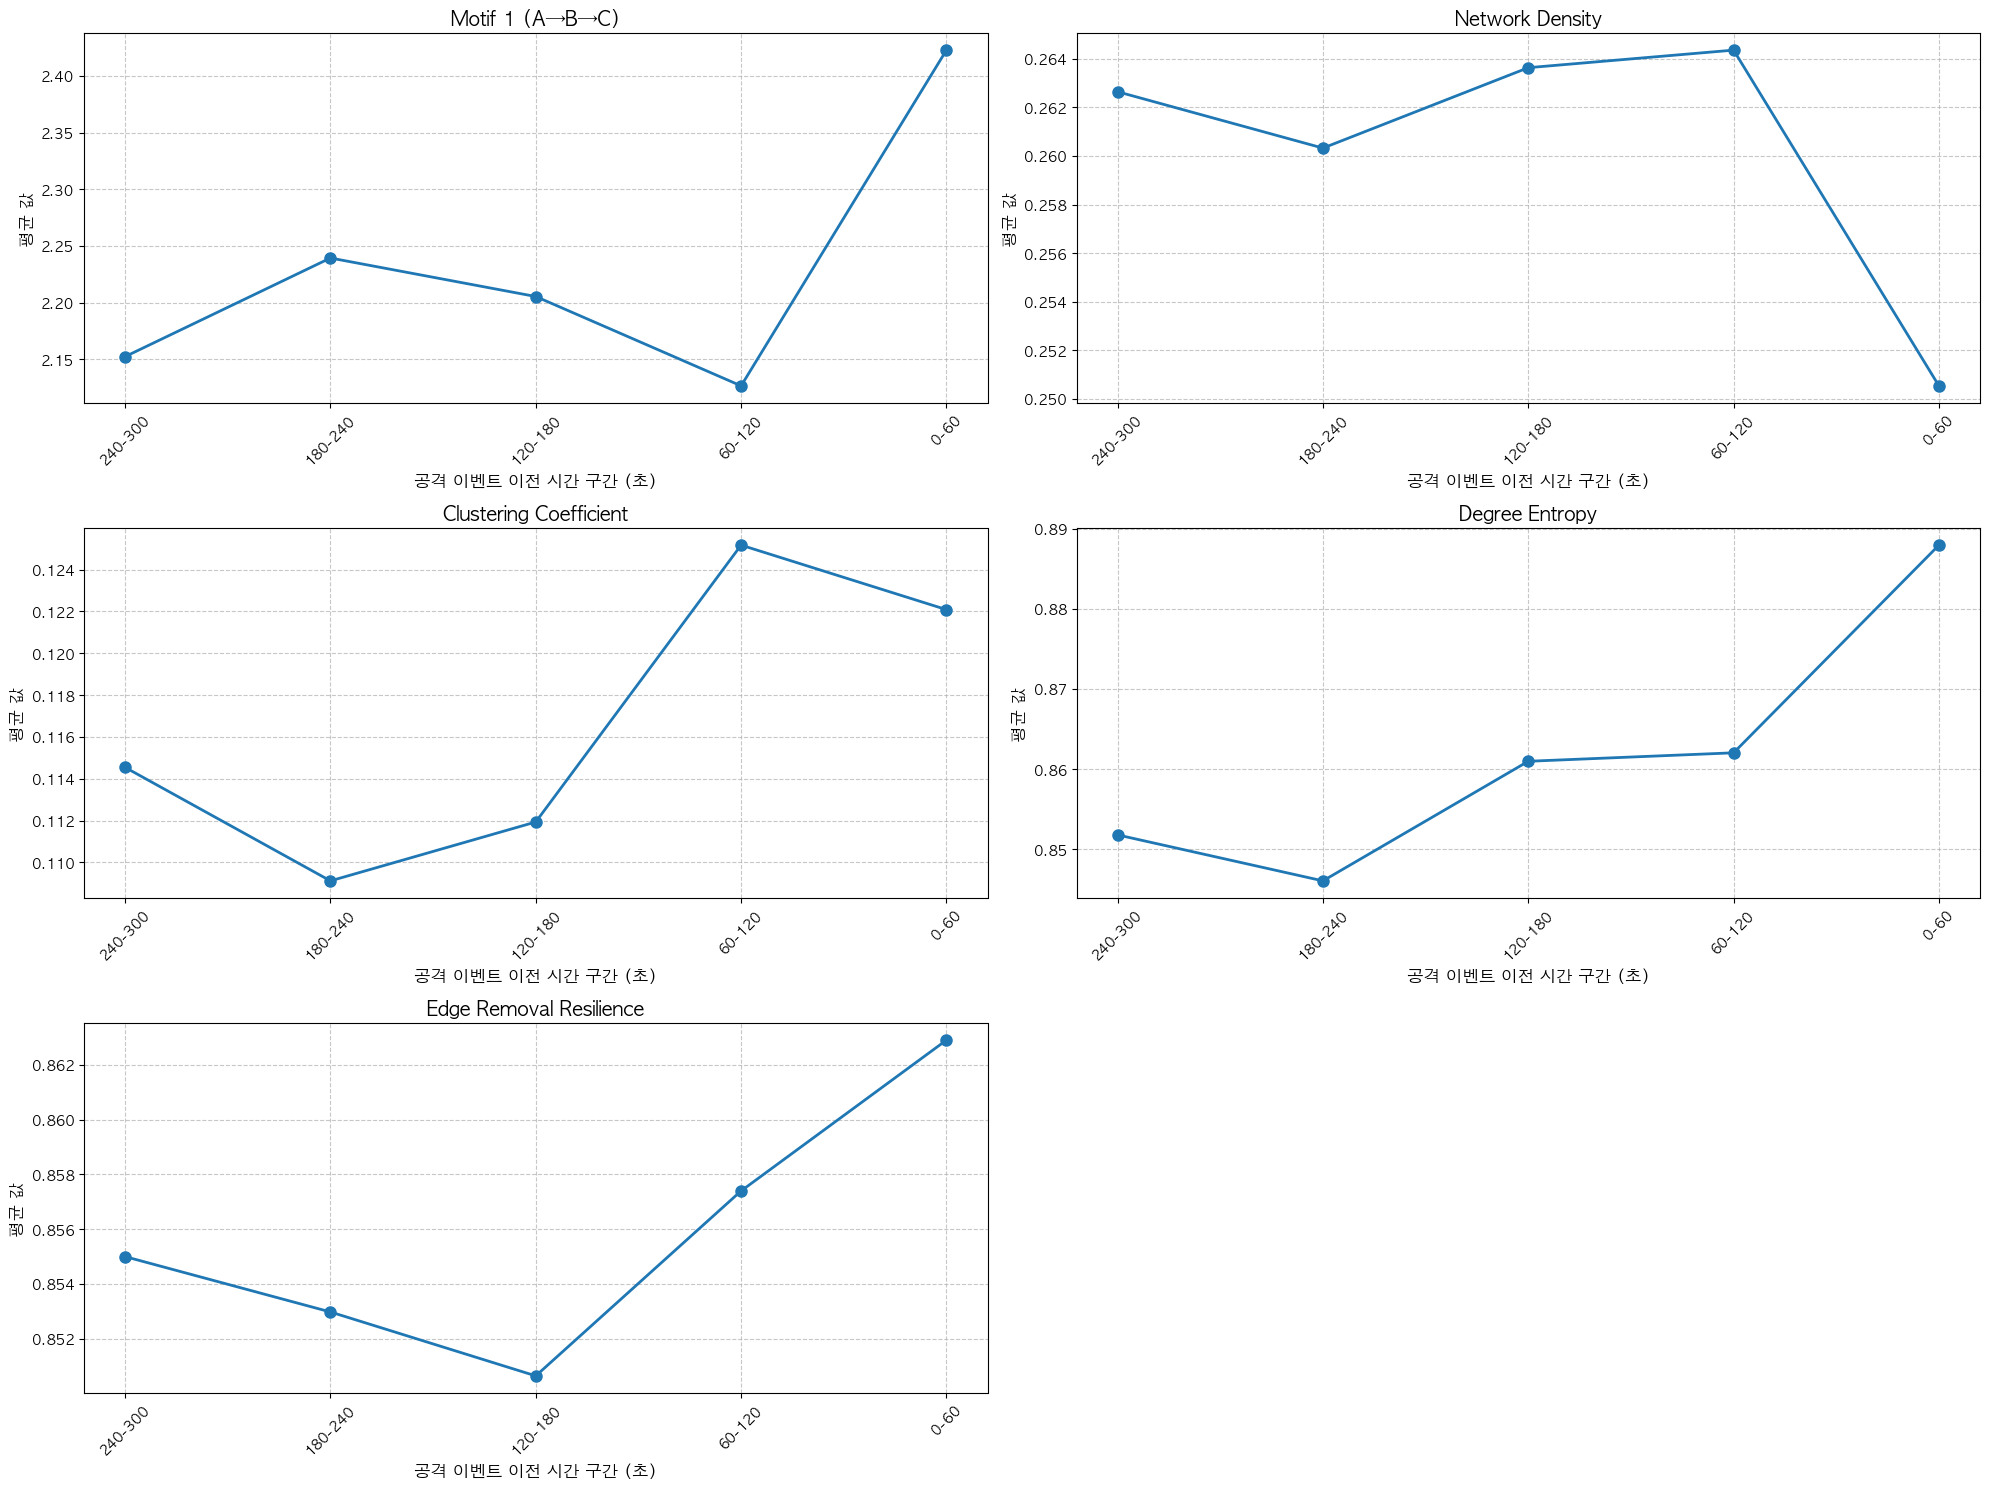

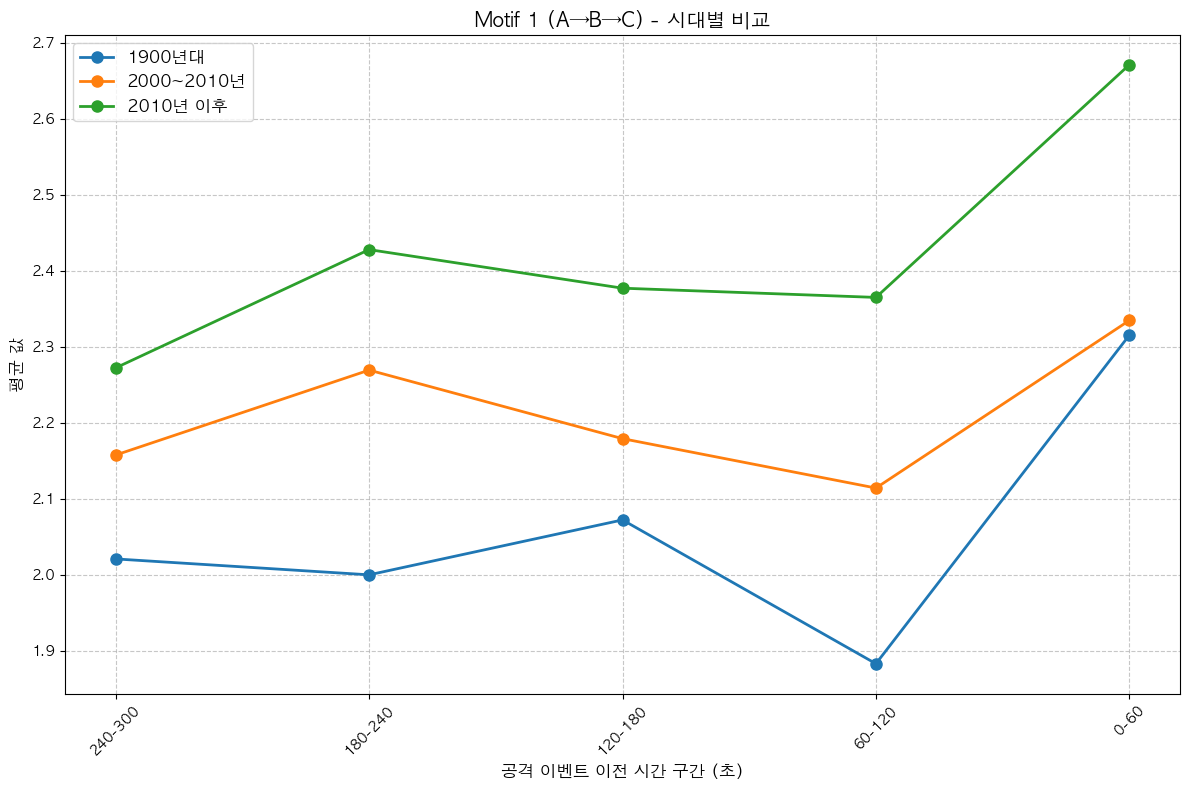

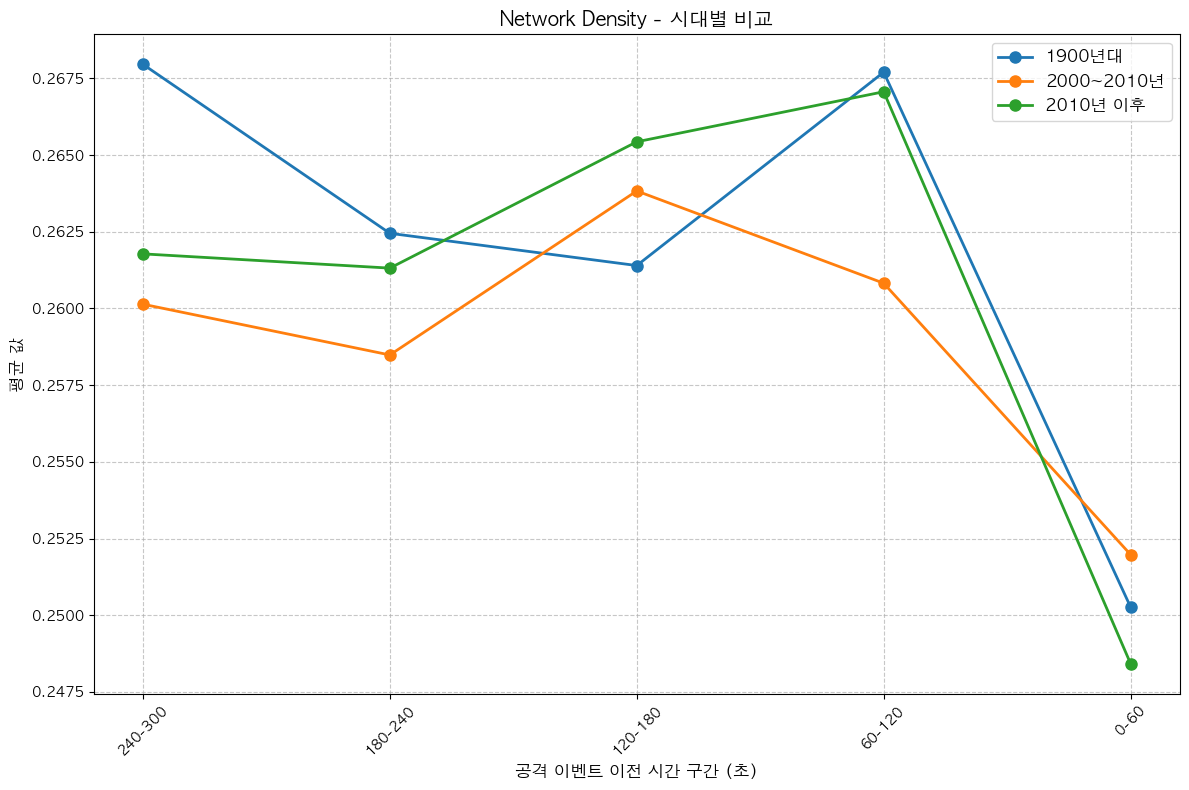

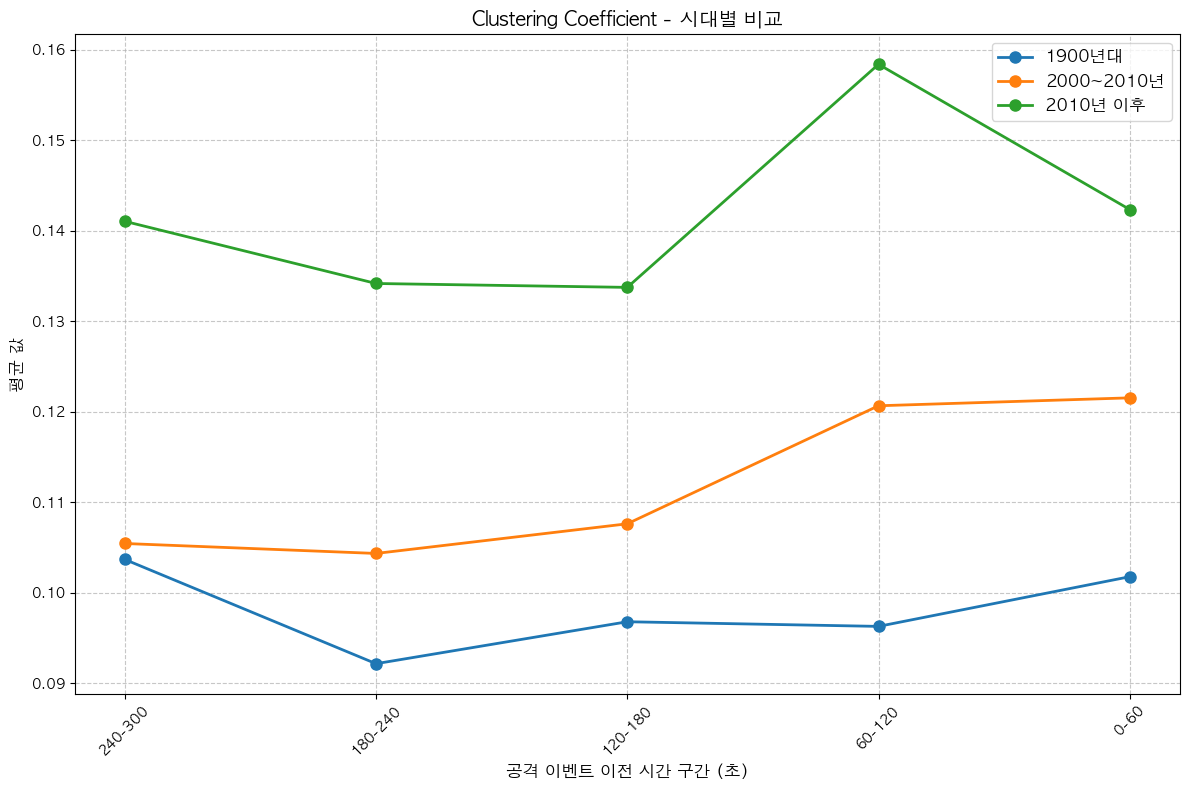

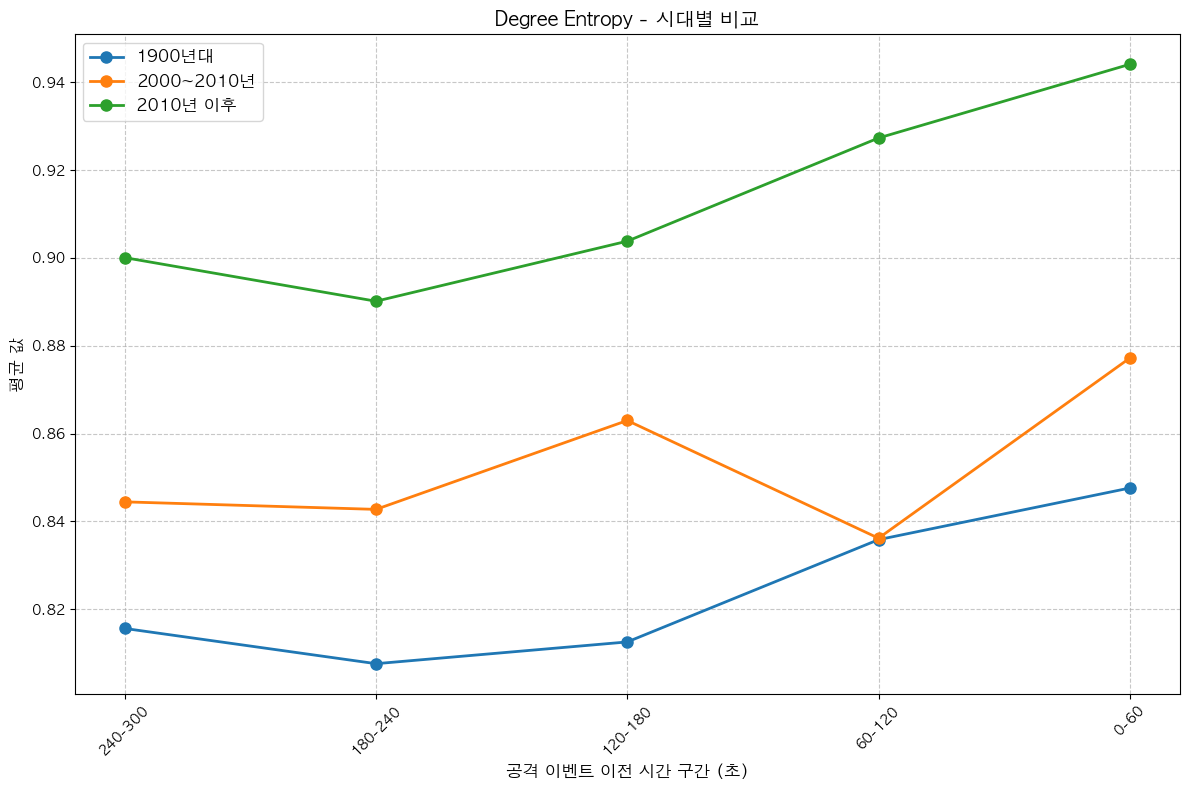

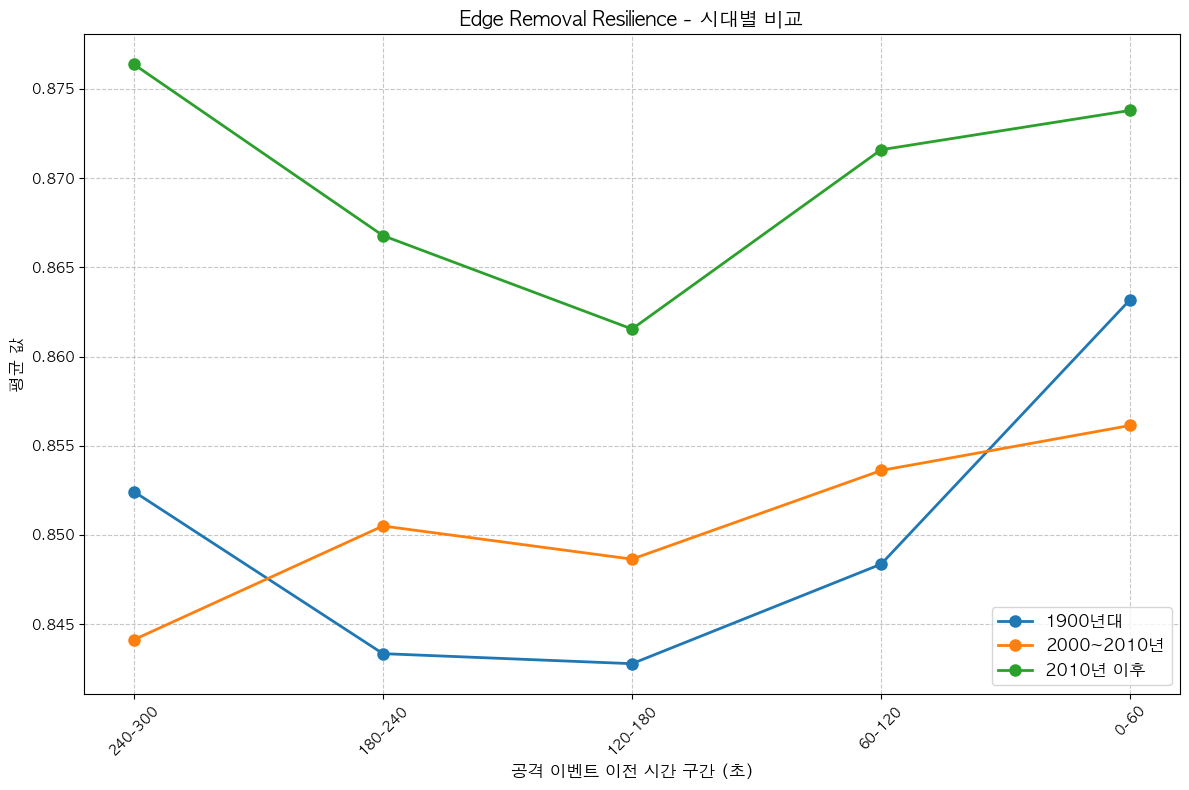

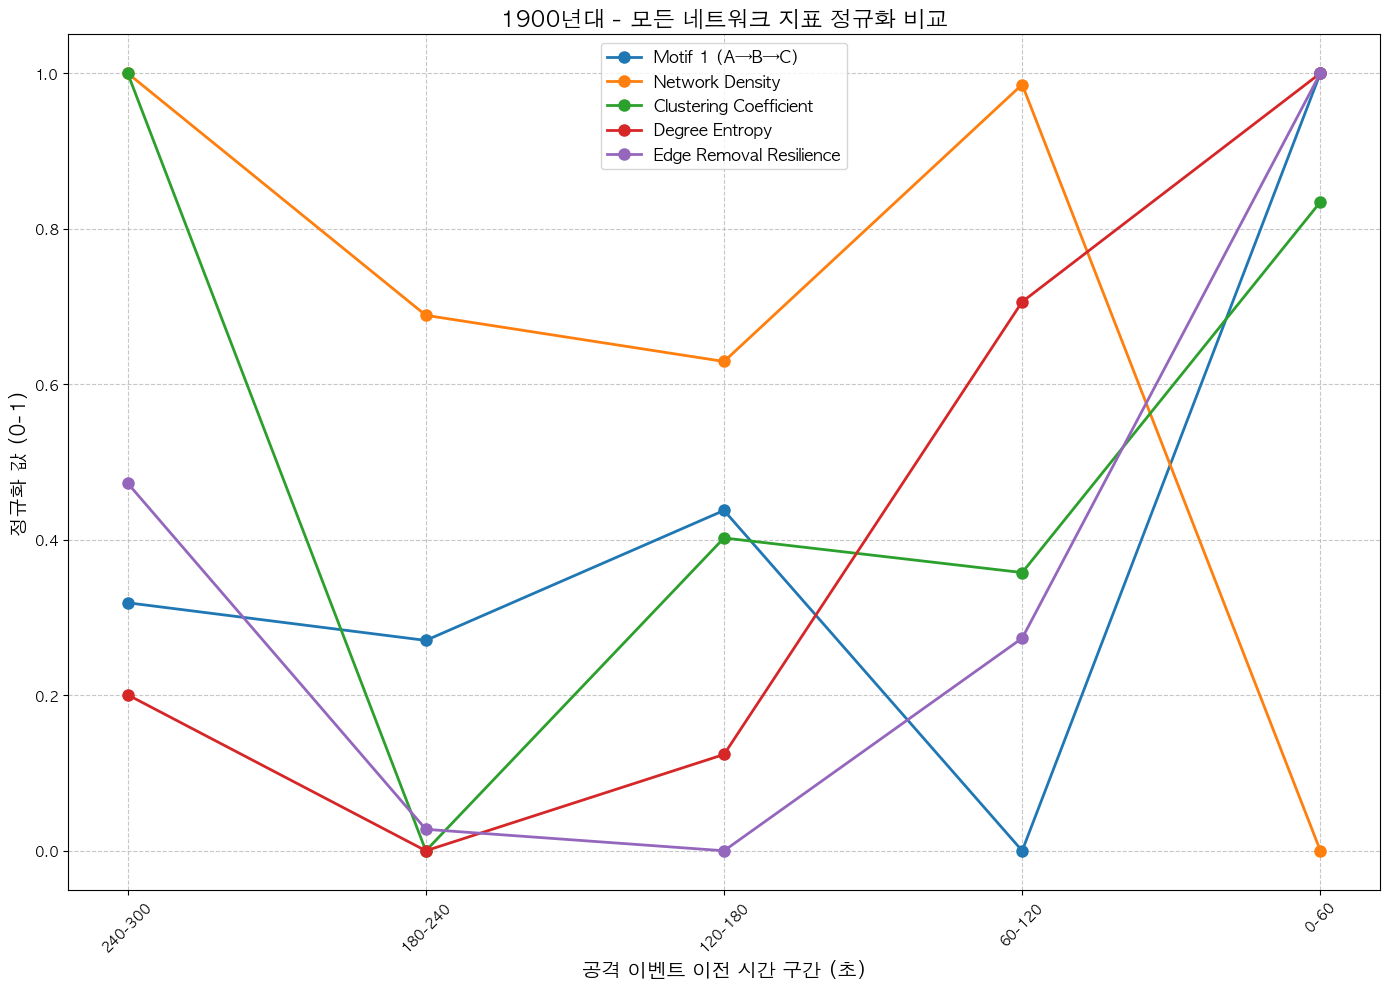

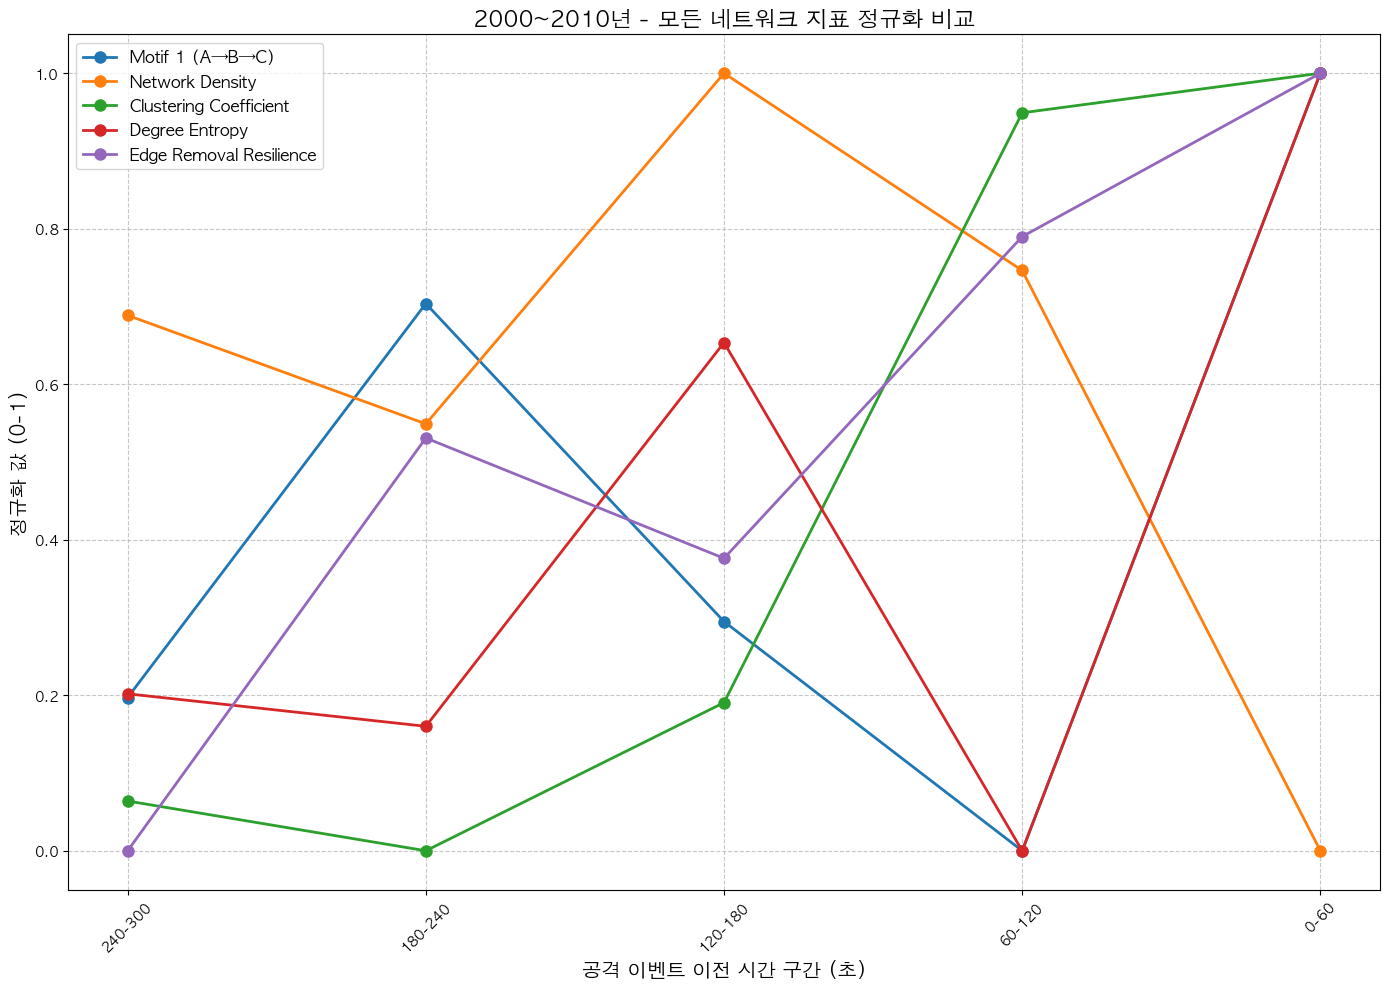

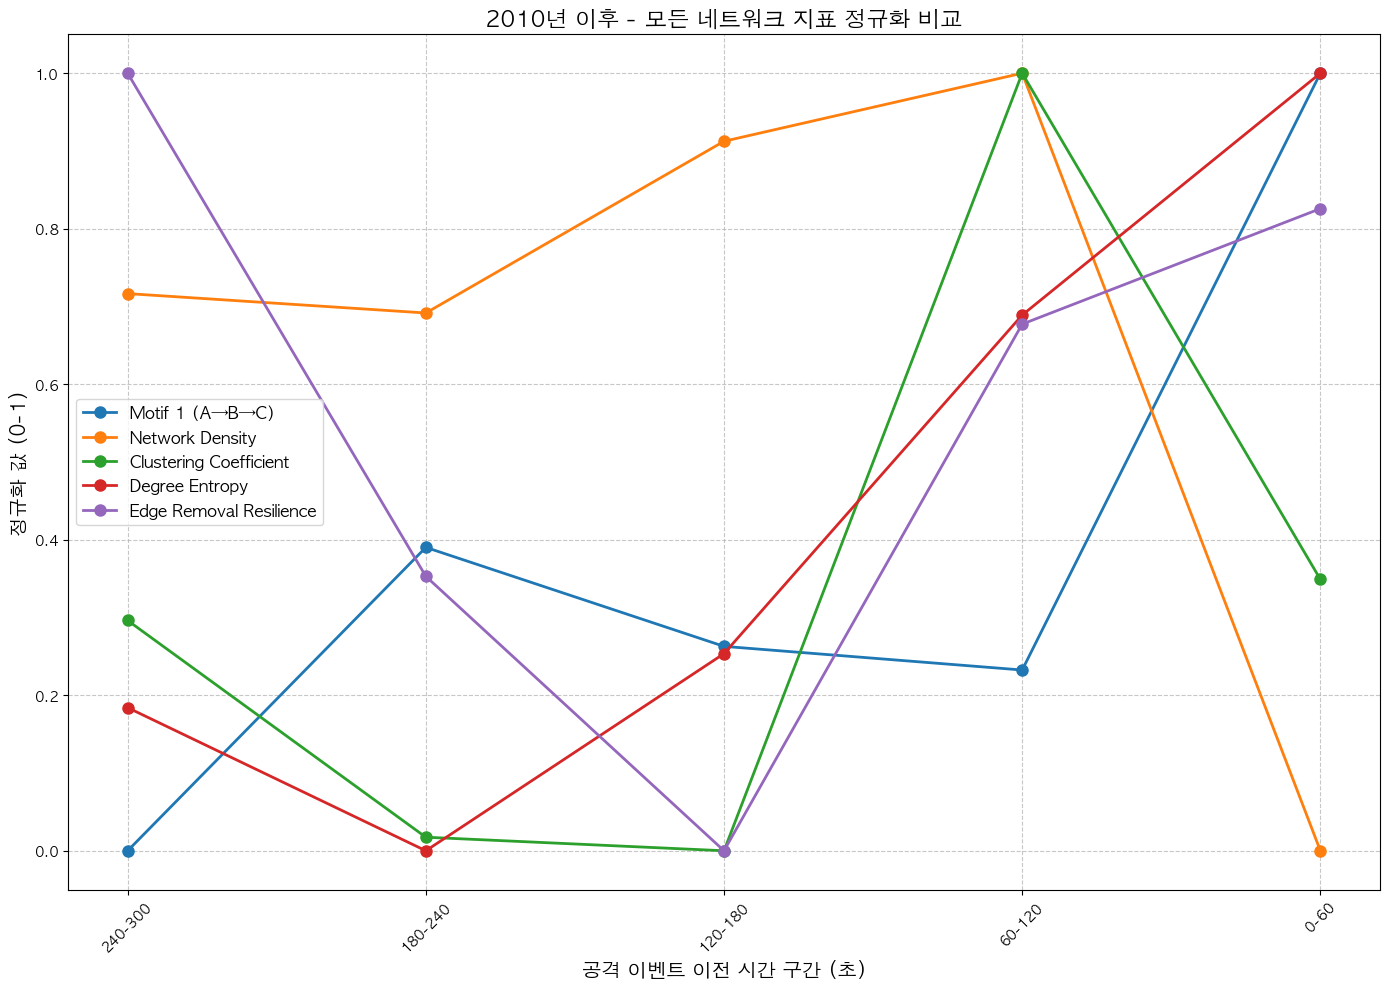

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import scipy.stats as stats
import itertools
from collections import Counter
import math
import os
import logging

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 한글 폰트 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------
# 기존 유틸리티 함수들 (기존 코드 유지)
# ------------------------------------------
def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info(f"Loaded data with shape: {df.shape}")
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
        logger.info(f"After filtering women's team, data shape: {df.shape}")
    else:
        available_columns = df.columns.tolist()
        logger.warning(f"'홈팀명' 열이 존재하지 않습니다. 사용 가능한 열: {available_columns}")
        raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
    return df

def preprocess_data(df):
    # 실패한 '패스'와 '볼터치' 제거
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    # '시간1'에서 분, 초 추출 및 초 단위 변환
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    # 프레임 값과 초를 사용하여 시간 변환 계수 산출
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    frame_diff = end_frame_val - start_frame_val
    time_diff = end_time_sec - start_time_sec
    conversion_factor = frame_diff / time_diff
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    # 경기별(경기일, 홈팀명, 상대팀명) 전후반 시간 통합
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
              for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    
    # Motif 1: A → B → C
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    
    # 3-노드 조합 검사
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    undirected_G = G.to_undirected()
    return nx.average_clustering(undirected_G) if len(undirected_G) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or len(G.edges()) == 0:
        return 0
    
    # 원래 네트워크의 Giant Component 크기 비율
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    
    # 엣지 가중치 기준 상위 20% 식별
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    
    # 상위 엣지 제거한 네트워크 생성
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    
    # 엣지 제거 후 Giant Component 크기 비율
    if len(G_removed.edges()) == 0:
        return 0
    
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    
    # 강건성 = 엣지 제거 후 남은 Giant Component 비율 / 원래 비율
    # 1에 가까울수록 강건함, 0에 가까울수록 취약함
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

# ------------------------------------------
# 공격 이벤트 시점 기준 시간 역추적 분석
# ------------------------------------------
def analyze_attack_buildup(df_sheet, window_size=120, max_lookback=300):
    # 연도 추출 및 시대 구분
    df_sheet['연도'] = df_sheet['경기일'].astype(str).str[:4].astype(int)
    df_sheet['시대'] = pd.cut(df_sheet['연도'], 
                          bins=[1900, 2000, 2010, 2025],
                          labels=['1900년대', '2000~2010년', '2010년 이후'])
    
    # 결과 저장용 리스트
    all_period_metrics = []
    
    # 경기별 분석
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)
    
    for game_key, game_df in games:
        # 게임 정보 및 시대 정보
        game_date, home_team, away_team = game_key
        era = game_df['시대'].iloc[0]
        
        # 공격 이벤트 시점 식별
        attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
        attack_times = sorted(attack_events["unified_time_sec"].tolist())
        
        # 각 공격 이벤트에 대해 역추적 분석
        for event_time in attack_times:
            if event_time < max_lookback:
                continue  # 충분한 역추적 시간이 없는 경우 제외
                
            # 구간 설정 (역으로 시간을 거슬러 올라가며)
            # 예: 0-60초, 60-120초, 120-180초, 180-240초, 240-300초
            for i in range(max_lookback // window_size):
                start_time_back = (i + 1) * window_size
                end_time_back = i * window_size
                
                # 실제 시간 계산 (공격 이벤트 시점으로부터 역으로)
                start_time = event_time - start_time_back
                end_time = event_time - end_time_back
                
                # 구간 라벨 설정
                period_label = f"{end_time_back}-{start_time_back}"
                
                # 해당 구간의 데이터 추출
                segment_df = game_df[(game_df["unified_time_sec"] >= start_time) & 
                                    (game_df["unified_time_sec"] <= end_time)]
                
                if len(segment_df) < 3:  # 최소 데이터 필요
                    continue
                    
                # 패스 네트워크 구축 및 지표 계산
                G = build_pass_network(segment_df)
                
                if G.number_of_nodes() <= 2:  # 모티프 분석을 위해 최소 3개 노드 필요
                    continue
                    
                # 지표 계산
                motif_counts = count_motifs(G)
                density = compute_density(G)
                clustering = compute_clustering(G)
                entropy = degree_entropy(G)
                edge_removal_resilience = compute_edge_removal_resilience(G)
                
                # 결과 저장
                metrics_row = {
                    '경기일': game_date,
                    '홈팀명': home_team,
                    '상대팀명': away_team,
                    '시대': era,
                    '구간': period_label,
                    '구간_시작': start_time_back,
                    '구간_끝': end_time_back,
                    'motif1': motif_counts[0],
                    'density': density,
                    'clustering': clustering,
                    'network_entropy': entropy,
                    'edge_removal_resilience': edge_removal_resilience
                    # 'nonlinearity_index' 항목 제거됨
                }
                all_period_metrics.append(metrics_row)
    
    # 데이터프레임으로 변환
    period_metrics_df = pd.DataFrame(all_period_metrics)
    
    # 전체 데이터에 대한 구간별 지표 평균 계산
    metrics = ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]  # 'nonlinearity_index' 제거됨
    overall_metrics = period_metrics_df.groupby('구간')[metrics].mean().reset_index()
    
    # 시대별, 구간별 지표 평균 계산
    era_metrics = period_metrics_df.groupby(['시대', '구간'])[metrics].mean().reset_index()
    
    return period_metrics_df, overall_metrics, era_metrics

# ------------------------------------------
# 메인 실행 함수
# ------------------------------------------
def main(file_path, sheet_name):
    # 결과 저장 폴더 생성
    output_dir = "축구_네트워크_역추적_분석"
    os.makedirs(output_dir, exist_ok=True)
    
    # 데이터 로드 및 전처리
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)
    
    # 공격 이벤트 시점 기준 시간 역추적 분석
    logger.info("공격 이벤트 시점 기준 시간 역추적 분석 중...")
    period_metrics_df, overall_metrics, era_metrics = analyze_attack_buildup(
        df_sheet, window_size=60, max_lookback=300)
    
    # 결과 저장
    period_metrics_df.to_csv(f"{output_dir}/공격_이벤트_역추적_모든_데이터.csv", index=False, encoding='utf-8-sig')
    overall_metrics.to_csv(f"{output_dir}/공격_이벤트_역추적_전체_평균.csv", index=False, encoding='utf-8-sig')
    era_metrics.to_csv(f"{output_dir}/공격_이벤트_역추적_시대별_평균.csv", index=False, encoding='utf-8-sig')
    
    logger.info("공격 이벤트 역추적 분석 완료")
    
    # 결과 시각화
    logger.info("공격 이벤트 역추적 데이터 시각화 중...")
    
    # 전체 데이터 시각화
    metrics = ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]  # 'nonlinearity_index' 제거됨
    metric_titles = {
        "motif1": "Motif 1 (A→B→C)",
        "density": "Network Density",
        "clustering": "Clustering Coefficient",
        "network_entropy": "Degree Entropy",
        "edge_removal_resilience": "Edge Removal Resilience"
        # "nonlinearity_index" 항목 제거됨
    }
    
    # 시간 순으로 정렬 (역추적이라 역순)
    overall_metrics['구간_시작'] = overall_metrics['구간'].str.split('-').str[1].astype(int)
    overall_metrics = overall_metrics.sort_values('구간_시작', ascending=False)
    
    # 각 지표별 시각화
    plt.figure(figsize=(20, 15))
    
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        plt.plot(overall_metrics['구간'], overall_metrics[metric], 'o-', linewidth=2, markersize=8)
        plt.title(metric_titles[metric], fontsize=14)
        plt.xlabel('공격 이벤트 이전 시간 구간 (초)', fontsize=12)
        plt.ylabel('평균 값', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/공격_이벤트_역추적_전체_평균.png", dpi=300, bbox_inches='tight')
    
    # 시대별 시각화 (각 지표별로)
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        
        # 시대별 데이터 준비
        for era in ['1900년대', '2000~2010년', '2010년 이후']:
            era_data = era_metrics[era_metrics['시대'] == era].copy()
            if len(era_data) == 0:
                continue
                
            era_data['구간_시작'] = era_data['구간'].str.split('-').str[1].astype(int)
            era_data = era_data.sort_values('구간_시작', ascending=False)
            
            plt.plot(era_data['구간'], era_data[metric], 'o-', linewidth=2, markersize=8, label=era)
        
        plt.title(f"{metric_titles[metric]} - 시대별 비교", fontsize=14)
        plt.xlabel('공격 이벤트 이전 시간 구간 (초)', fontsize=12)
        plt.ylabel('평균 값', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/공격_이벤트_역추적_{metric}_시대별_비교.png", dpi=300, bbox_inches='tight')
    
    # 모든 지표의 시대별 비교를 한 그래프로 (정규화 버전)
    for era in ['1900년대', '2000~2010년', '2010년 이후']:
        era_data = era_metrics[era_metrics['시대'] == era].copy()
        if len(era_data) == 0:
            continue
            
        era_data['구간_시작'] = era_data['구간'].str.split('-').str[1].astype(int)
        era_data = era_data.sort_values('구간_시작', ascending=False)
        
        # 정규화를 위한 처리
        normalized_data = era_data.copy()
        for metric in metrics:
            min_val = normalized_data[metric].min()
            max_val = normalized_data[metric].max()
            if max_val > min_val:  # 분모가 0이 되지 않도록
                normalized_data[metric] = (normalized_data[metric] - min_val) / (max_val - min_val)
        
        plt.figure(figsize=(14, 10))
        for metric in metrics:
            plt.plot(normalized_data['구간'], normalized_data[metric], 'o-', 
                    linewidth=2, markersize=8, label=metric_titles[metric])
        
        plt.title(f"{era} - 모든 네트워크 지표 정규화 비교", fontsize=16)
        plt.xlabel('공격 이벤트 이전 시간 구간 (초)', fontsize=14)
        plt.ylabel('정규화 값 (0-1)', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, loc='best')
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{era}_모든_지표_정규화_비교.png", dpi=300, bbox_inches='tight')
    
    logger.info("시각화 완료")
    
    logger.info(f"모든 분석이 완료되었습니다. 결과는 '{output_dir}' 폴더에 저장되었습니다.")
    
    return period_metrics_df, overall_metrics, era_metrics

if __name__ == "__main__":
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'
    period_metrics_df, overall_metrics, era_metrics = main(file_path, sheet_name)

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
import math
from collections import Counter
import logging
import os
from statsmodels.stats.multitest import multipletests

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 결과 저장 폴더 생성
OUTPUT_DIR = "attack_nonattack_comparison"
os.makedirs(OUTPUT_DIR, exist_ok=True)
logger.info(f"결과가 {OUTPUT_DIR} 폴더에 저장됩니다.")

# ----------------------------
# p-value 포맷팅 함수 추가
# ----------------------------
def format_pvalue(p_val):
    if p_val < 1e-20:  # 극도로 작은 값
        return f"{p_val:.20e}"
    elif p_val < 1e-10:  # 매우 작은 값
        return f"{p_val:.20f}"
    elif p_val < 0.0001:  # 작은 값
        return f"{p_val:.10f}"
    else:  # 일반적인 값
        return f"{p_val:.6f}"

def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
    logger.info("Loaded data with shape: %s", df.shape)
    if "홈팀명" in df.columns:
        df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
    else:
        raise ValueError("'홈팀명' 열이 존재하지 않습니다.")
    return df

def preprocess_data(df):
    # 실패한 '패스'와 '볼터치' 제거
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    # '시간1'에서 분, 초 추출 후 초 단위 변환
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    # 프레임 값과 초를 이용한 시간 변환 계수 산출
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    conversion_factor = (end_frame_val - start_frame_val) / (end_time_sec - start_time_sec)
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    # 경기별 전후반 시간 통합
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
             for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    return motifs

def is_isomorphic(G1, G2):
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def compute_clustering(G):
    return nx.average_clustering(G.to_undirected()) if len(G.nodes()) > 0 else 0

def degree_entropy(G):
    degrees = [d for n, d in G.degree()]
    total = len(degrees)
    if total == 0:
        return 0
    count = Counter(degrees)
    entropy = -sum((freq/total) * math.log(freq/total + 1e-9) for freq in count.values())
    return entropy

def compute_edge_removal_resilience(G):
    if len(G.nodes()) <= 1 or G.number_of_edges() == 0:
        return 0
    original_gc = max(nx.weakly_connected_components(G), key=len)
    original_gc_ratio = len(original_gc) / len(G.nodes())
    edge_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    top_edges = edge_weights[:max(1, int(len(edge_weights) * 0.2))]
    G_removed = G.copy()
    for u, v, _ in top_edges:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    if G_removed.number_of_edges() == 0:
        return 0
    gc_after_removal = max(nx.weakly_connected_components(G_removed), key=len)
    gc_ratio_after_removal = len(gc_after_removal) / len(G.nodes())
    resilience = gc_ratio_after_removal / original_gc_ratio if original_gc_ratio > 0 else 0
    return resilience

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],
        "density": [],
        "clustering": [],
        "network_entropy": [],
        "edge_removal_resilience": []
    }
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:
            continue
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        metrics["density"].append(compute_density(G))
        metrics["clustering"].append(compute_clustering(G))
        metrics["network_entropy"].append(degree_entropy(G))
        metrics["edge_removal_resilience"].append(compute_edge_removal_resilience(G))
    return metrics

def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    # 합동 표준편차(pooled standard deviation) 계산
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
    
    # 평균 차이를 합동 표준편차로 나눔
    return np.abs(np.mean(x) - np.mean(y)) / pooled_std

def mann_whitney_effect_size(u_stat, n1, n2):
    return np.abs(1 - (2 * u_stat) / (n1 * n2))

def interpret_effect_size(d):
    if d < 0.2:
        return "매우 작음"
    elif d < 0.5:
        return "작음"
    elif d < 0.8:
        return "중간"
    else:
        return "큼"

def normality_test(data, alpha=0.05):
    try:
        # 데이터가 너무 많으면 샘플링
        if len(data) > 5000:
            data = np.random.choice(data, size=5000, replace=False)
        stat, p = shapiro(data)
        return p > alpha  # True면 정규 분포 가정을 기각하지 않음
    except:
        return False  # 오류 발생 시 정규 분포 아님으로 간주

def visualize_distributions(metrics_df, metrics_list, output_dir):
    attack_data = metrics_df[metrics_df['구간유형'] == '공격']
    nonattack_data = metrics_df[metrics_df['구간유형'] == '비공격']
    
    for metric in metrics_list:
        plt.figure(figsize=(12, 6))
        
        # 박스플롯
        plt.subplot(1, 2, 1)
        boxplot_data = [
            attack_data[metric].dropna().values,
            nonattack_data[metric].dropna().values
        ]
        sns.boxplot(data=boxplot_data)
        plt.xticks([0, 1], ['공격', '비공격'])
        plt.title(f'{metric} 분포 (박스플롯)')
        
        # 바이올린 플롯
        plt.subplot(1, 2, 2)
        sns.violinplot(x='구간유형', y=metric, data=metrics_df, 
                     order=['공격', '비공격'], inner='quartile')
        plt.title(f'{metric} 분포 (바이올린 플롯)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric}_distribution.png'))
        plt.close()

def main():
    # 파일 및 시트 설정
    file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
    sheet_name = '대표팀(~10)'

    # 데이터 로드 및 전처리
    df_sheet = load_data(file_path, sheet_name)
    df_sheet = preprocess_data(df_sheet)

    # 경기별로 그룹화
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    games = df_sheet.groupby(group_cols)

    # 각 게임별 공격 및 비공격 구간 지표 수집
    all_game_metrics = []
    for game_key, game_df in games:
        attack_intervals = get_attack_intervals(game_df, window=180)
        nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
        
        attack_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
        nonattack_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
        
        for i in range(len(attack_metrics.get('motif1', []))):
            metrics_row = {
                '경기일': game_key[0],
                '홈팀명': game_key[1],
                '상대팀명': game_key[2],
                '구간유형': '공격'
            }
            for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:
                metrics_row[metric] = attack_metrics.get(metric, [None])[i]
            all_game_metrics.append(metrics_row)
        
        for i in range(len(nonattack_metrics.get('motif1', []))):
            metrics_row = {
                '경기일': game_key[0],
                '홈팀명': game_key[1],
                '상대팀명': game_key[2],
                '구간유형': '비공격'
            }
            for metric in ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]:
                metrics_row[metric] = nonattack_metrics.get(metric, [None])[i]
            all_game_metrics.append(metrics_row)

    # 수집한 결과를 데이터프레임으로 변환
    metrics_df = pd.DataFrame(all_game_metrics)
    logger.info("총 측정 구간 수: %d", len(metrics_df))

    # 데이터 분포 시각화
    metrics_list = ["motif1", "density", "clustering", "network_entropy", "edge_removal_resilience"]
    visualize_distributions(metrics_df, metrics_list, OUTPUT_DIR)

    # 공격과 비공격 그룹 분리
    attack_data = metrics_df[metrics_df['구간유형'] == '공격']
    nonattack_data = metrics_df[metrics_df['구간유형'] == '비공격']

    # 결과 저장을 위한 데이터프레임 생성
    results_df = pd.DataFrame(columns=[
        '지표', '공격_평균', '공격_표준편차', '비공격_평균', '비공격_표준편차',
        '정규성_검정_통과', 't검정_통계량', 't검정_p값', 'Mann-Whitney_U', 'Mann-Whitney_p값',
        'Cohen_d', 'Mann-Whitney_r', '효과크기_해석'
    ])
    
    # p-value 보정을 위한 리스트
    t_test_pvalues = []
    mw_test_pvalues = []

    # 각 지표별 통계 검정
    for metric in metrics_list:
        attack_metric = attack_data[metric].dropna()
        nonattack_metric = nonattack_data[metric].dropna()
        
        # 기술 통계량
        attack_mean = attack_metric.mean()
        attack_std = attack_metric.std()
        nonattack_mean = nonattack_metric.mean()
        nonattack_std = nonattack_metric.std()
        
        # 정규성 검정
        normality_attack = normality_test(attack_metric)
        normality_nonattack = normality_test(nonattack_metric)
        normality_passed = normality_attack and normality_nonattack
        
        # t-검정 (Welch의 t-test)
        t_stat, p_value_t = ttest_ind(attack_metric, nonattack_metric, equal_var=False)
        t_test_pvalues.append(p_value_t)
        
        # Mann–Whitney U 검정
        u_stat, p_value_u = mannwhitneyu(attack_metric, nonattack_metric, alternative='two-sided')
        mw_test_pvalues.append(p_value_u)
        
        # 효과 크기 계산
        effect_size_d = cohen_d(attack_metric, nonattack_metric)
        effect_size_r = mann_whitney_effect_size(u_stat, len(attack_metric), len(nonattack_metric))
        effect_size_interpretation = interpret_effect_size(effect_size_d)
        
        # 결과 저장
        results_df = pd.concat([results_df, pd.DataFrame([{
            '지표': metric,
            '공격_평균': attack_mean,
            '공격_표준편차': attack_std,
            '비공격_평균': nonattack_mean,
            '비공격_표준편차': nonattack_std,
            '정규성_검정_통과': normality_passed,
            't검정_통계량': t_stat,
            't검정_p값': p_value_t,
            'Mann-Whitney_U': u_stat,
            'Mann-Whitney_p값': p_value_u,
            'Cohen_d': effect_size_d,
            'Mann-Whitney_r': effect_size_r,
            '효과크기_해석': effect_size_interpretation
        }])], ignore_index=True)
    
    # 다중 비교 문제 보정 (Benjamini-Hochberg FDR)
    _, p_adjusted_t, _, _ = multipletests(t_test_pvalues, method='fdr_bh')
    _, p_adjusted_u, _, _ = multipletests(mw_test_pvalues, method='fdr_bh')
    
    # 보정된 p-value 추가
    results_df['t검정_p값_보정'] = p_adjusted_t
    results_df['Mann-Whitney_p값_보정'] = p_adjusted_u
    
    # p-value 형식화된 값 추가
    results_df['t검정_p값_포맷'] = results_df['t검정_p값'].apply(format_pvalue)
    results_df['Mann-Whitney_p값_포맷'] = results_df['Mann-Whitney_p값'].apply(format_pvalue)
    results_df['t검정_p값_보정_포맷'] = results_df['t검정_p값_보정'].apply(format_pvalue)
    results_df['Mann-Whitney_p값_보정_포맷'] = results_df['Mann-Whitney_p값_보정'].apply(format_pvalue)
    
    # 결과 출력
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    # 소수점 이하 자릿수를 더 많이 표시하도록 설정 (원래 값 표시용)
    pd.set_option('display.float_format', '{:.15e}'.format)
    
    print("\n공격 vs 비공격 구간의 통계 검정 결과:")
    
    # 보기 좋게 출력할 열 선택 (형식화된 p-value 사용)
    display_columns = [
        '지표', '공격_평균', '공격_표준편차', '비공격_평균', '비공격_표준편차',
        '정규성_검정_통과', 't검정_통계량', 't검정_p값_포맷', 'Mann-Whitney_U', 
        'Mann-Whitney_p값_포맷', 'Cohen_d', 'Mann-Whitney_r', '효과크기_해석',
        't검정_p값_보정_포맷', 'Mann-Whitney_p값_보정_포맷'
    ]
    
    print(results_df[display_columns])
    
    # 결과 저장 (원래 값과 형식화된 값 모두 포함)
    results_df.to_csv(os.path.join(OUTPUT_DIR, 'attack_nonattack_comparison_results.csv'), 
                      index=False, encoding='utf-8-sig')
    logger.info(f"결과가 {os.path.join(OUTPUT_DIR, 'attack_nonattack_comparison_results.csv')}에 저장되었습니다.")
    
    # 효과 크기 시각화
    plt.figure(figsize=(10, 6))
    metrics_order = results_df.sort_values(by='Cohen_d', ascending=False)['지표'].tolist()
    effect_sizes = results_df.set_index('지표').loc[metrics_order, 'Cohen_d'].values
    
    colors = ['skyblue' if x < 0.2 else 'lightgreen' if x < 0.5 else 'orange' if x < 0.8 else 'salmon' for x in effect_sizes]
    
    bars = plt.bar(metrics_order, effect_sizes, color=colors)
    plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='작은 효과 (0.2)')
    plt.axhline(y=0.5, color='gray', linestyle='-.', alpha=0.7, label='중간 효과 (0.5)')
    plt.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='큰 효과 (0.8)')
    
    plt.ylabel("효과 크기 (Cohen's d)")
    plt.title("공격 vs 비공격 구간 네트워크 지표의 효과 크기")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'effect_size_comparison.png'))
    plt.close()
    
    # 각 지표 별 평균 비교 그래프
    plt.figure(figsize=(12, 8))
    
    # 지표 정규화를 위한 전처리
    normalized_results = pd.DataFrame()
    for metric in metrics_list:
        max_val = max(results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0],
                      results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0])
        min_val = min(results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0],
                      results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0])
        range_val = max_val - min_val
        
        if range_val == 0:  # 값이 같으면
            normalized_results.loc[metric, '공격'] = 0.5
            normalized_results.loc[metric, '비공격'] = 0.5
        else:
            normalized_results.loc[metric, '공격'] = (results_df.loc[results_df['지표'] == metric, '공격_평균'].values[0] - min_val) / range_val
            normalized_results.loc[metric, '비공격'] = (results_df.loc[results_df['지표'] == metric, '비공격_평균'].values[0] - min_val) / range_val
    
    # 방사형 그래프 (레이더 차트)
    categories = metrics_list
    N = len(categories)
    
    # 각도 설정
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # 원 닫기
    
    ax = plt.subplot(111, polar=True)
    
    # 그리드 각도 설정
    plt.xticks(angles[:-1], categories, size=12)
    
    # y축 그리드 제거 및 범위 설정
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # 데이터 플롯
    attack_values = normalized_results['공격'].values.tolist()
    attack_values += attack_values[:1]  # 원 닫기
    ax.plot(angles, attack_values, linewidth=2, linestyle='solid', label="공격")
    ax.fill(angles, attack_values, 'b', alpha=0.1)
    
    nonattack_values = normalized_results['비공격'].values.tolist()
    nonattack_values += nonattack_values[:1]  # 원 닫기
    ax.plot(angles, nonattack_values, linewidth=2, linestyle='solid', label="비공격")
    ax.fill(angles, nonattack_values, 'r', alpha=0.1)
    
    # 제목 및 범례
    plt.title('공격 vs 비공격 구간 네트워크 지표 비교 (정규화)', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'radar_chart_comparison.png'))
    plt.close()

# 메인 함수 실행
if __name__ == "__main__":
    main()

INFO:__main__:결과가 attack_nonattack_comparison 폴더에 저장됩니다.
INFO:__main__:Loaded data with shape: (389139, 16)
INFO:__main__:총 측정 구간 수: 6380
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
IN


공격 vs 비공격 구간의 통계 검정 결과:
                        지표                 공격_평균               공격_표준편차                비공격_평균              비공격_표준편차 정규성_검정_통과                t검정_통계량                   t검정_p값_포맷        Mann-Whitney_U          Mann-Whitney_p값_포맷               Cohen_d        Mann-Whitney_r 효과크기_해석                t검정_p값_보정_포맷       Mann-Whitney_p값_보정_포맷
0                   motif1 4.174919843249020e+00 3.490804249898065e+00 3.512174643157011e+00 3.120064766023798e+00     False  7.884387169887630e+00      0.00000000000000376289 5.572474500000000e+06      0.00000000000001447241 2.015449171101691e-01 1.112266712372243e-01      작음      0.00000000000000940722      0.00000000000002412069
1                  density 2.154500894347706e-01 7.543335005290752e-02 2.194289267966850e-01 8.689785964319371e-02     False -1.955359707435741e+00                    0.050585 5.015762000000000e+06                    0.988450 4.849187325138216e-02 2.106803679697844e-04   매우 작음                    0.050585  

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
import math
from collections import Counter
import os
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 결과 저장 폴더 생성
OUTPUT_DIR = "density_motif1_trends"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def to_min_sec(total_seconds):
    m = int(total_seconds // 60)
    s = int(total_seconds % 60)
    return f"{m}' {s}''"

def unify_half_times(group):
    first_half = group["전후반"] == "전반"
    half_end = group.loc[first_half, "converted_time_sec"].max() if first_half.any() else 0
    group["unified_time_sec"] = group.apply(
        lambda row: row["converted_time_sec"] if row["전후반"] == "전반" 
                    else half_end + row["converted_time_sec"], axis=1)
    return group

def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
        print(f"로드된 데이터 크기: {df.shape}")
        if "홈팀명" in df.columns:
            df = df[df["홈팀명"] != "대한민국 여자국가대표팀"].copy()
        else:
            raise ValueError("'홈팀명' 열이 존재하지 않습니다. 실제 열 이름을 확인하세요.")
        return df
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

def preprocess_data(df):
    # 실패한 '패스'와 '볼터치' 제거
    df = df[~(((df["이벤트명"].isin(["패스", "볼터치"])) & (df["성공/실패"] == "F")))].copy()
    
    # '시간1'에서 분, 초 추출 및 초 단위 변환
    time_extract = df["시간1"].astype(str).str.extract(r"(\d+)[']\s*(\d+)[']{2}")
    df["time_in_sec"] = time_extract[0].astype(int) * 60 + time_extract[1].astype(int)
    
    # 프레임 값과 초를 사용하여 시간 변환 계수 산출
    start_frame_val = df.iloc[0]['시간']
    start_time_sec = df.iloc[0]['time_in_sec']
    end_frame_val = df.iloc[-1]['시간']
    end_time_sec = df.iloc[-1]['time_in_sec']
    frame_diff = end_frame_val - start_frame_val
    time_diff = end_time_sec - start_time_sec
    conversion_factor = frame_diff / time_diff
    df["converted_time_sec"] = (df["시간"] - start_frame_val) / conversion_factor
    
    # 경기별 전후반 시간 통합
    group_cols = ["경기일", "홈팀명", "상대팀명"]
    df = df.groupby(group_cols, group_keys=False).apply(unify_half_times)
    df["unified_time_str"] = df["unified_time_sec"].apply(to_min_sec)
    return df

def build_pass_network(segment_df):
    segment_df = segment_df.sort_values("unified_time_sec")
    edges = [(segment_df.iloc[i]["선수명"], segment_df.iloc[i+1]["선수명"])
              for i in range(len(segment_df)-1)
             if segment_df.iloc[i]["이벤트명"] == "패스" 
             and segment_df.iloc[i+1]["이벤트명"] in ["패스", "볼터치"]]
    
    G = nx.DiGraph()
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def define_motifs():
    motifs = []
    
    # Motif 1: A → B → C
    g1 = nx.DiGraph()
    g1.add_edges_from([(0, 1), (1, 2)])
    motifs.append(g1)
    
    return motifs

def is_isomorphic(G1, G2):
    # G1: motif, G2: subgraph
    adj1 = nx.adjacency_matrix(G1, nodelist=sorted(G1.nodes())).todense()
    nodes2 = sorted(G2.nodes())
    for perm in itertools.permutations(nodes2):
        adj2 = nx.adjacency_matrix(G2, nodelist=list(perm)).todense()
        if np.array_equal(adj1, adj2):
            return True
    return False

def count_motifs(target_graph):
    motifs = define_motifs()
    counts = [0] * len(motifs)
    
    # 3-노드 조합 검사
    for nodes in itertools.combinations(target_graph.nodes(), 3):
        subg = target_graph.subgraph(nodes).copy()
        if not nx.is_weakly_connected(subg):
            continue
        for i, motif in enumerate(motifs):
            if is_isomorphic(motif, subg):
                counts[i] += 1
                break
    
    return counts

def compute_density(G):
    n = len(G.nodes())
    return G.number_of_edges() / (n * (n - 1)) if n > 1 else 0

def get_attack_intervals(game_df, window=180):
    attack_events = game_df[game_df["이벤트명"].isin(["골인", "유효슈팅", "슈팅"])]
    attack_times = sorted(attack_events["unified_time_sec"].tolist())
    attack_intervals = []
    used_intervals = []
    for t in attack_times:
        if t < window:
            continue
        interval = (t - window, t)
        if not any(not (interval[1] <= ui[0] or interval[0] >= ui[1]) for ui in used_intervals):
            used_intervals.append(interval)
            attack_intervals.append(interval)
    return attack_intervals

def get_nonattack_intervals(game_df, window=180, attack_intervals=[]):
    game_start = game_df["unified_time_sec"].min()
    game_end = game_df["unified_time_sec"].max()
    nonattack_intervals = []
    current = game_start
    while current + window <= game_end:
        seg = (current, current + window)
        if not any(not (seg[1] <= ai[0] or seg[0] >= ai[1]) for ai in attack_intervals):
            nonattack_intervals.append(seg)
        current += window
    return nonattack_intervals

def compute_metrics_for_intervals(intervals, game_df):
    metrics = {
        "motif1": [],
        "density": []
    }
    
    for interval in intervals:
        seg_df = game_df[(game_df["unified_time_sec"] >= interval[0]) & 
                         (game_df["unified_time_sec"] <= interval[1])]
        if seg_df.empty:
            continue
            
        G = build_pass_network(seg_df)
        if G.number_of_nodes() <= 2:  
            continue
            
        # 모티프 카운팅 (모티프 1만)
        motif_counts = count_motifs(G)
        metrics["motif1"].append(motif_counts[0])
        
        # 밀도 계산
        density = compute_density(G)
        metrics["density"].append(density)
        
    return metrics

def create_combined_metrics(attack_intervals_df, nonattack_intervals_df):
    # 1. 지표 비율: motif1 / density
    attack_intervals_df['motif1_to_density'] = attack_intervals_df['motif1'] / (attack_intervals_df['density'] + 1e-9)
    nonattack_intervals_df['motif1_to_density'] = nonattack_intervals_df['motif1'] / (nonattack_intervals_df['density'] + 1e-9)
    
    # 2. 표준화된 지표 차이: 정규화된(motif1 - density)
    # 먼저 각 지표를 정규화
    all_motif1 = np.concatenate([attack_intervals_df['motif1'], nonattack_intervals_df['motif1']])
    all_density = np.concatenate([attack_intervals_df['density'], nonattack_intervals_df['density']])
    
    motif1_mean, motif1_std = np.mean(all_motif1), np.std(all_motif1)
    density_mean, density_std = np.mean(all_density), np.std(all_density)
    
    attack_intervals_df['motif1_norm'] = (attack_intervals_df['motif1'] - motif1_mean) / motif1_std
    attack_intervals_df['density_norm'] = (attack_intervals_df['density'] - density_mean) / density_std
    
    nonattack_intervals_df['motif1_norm'] = (nonattack_intervals_df['motif1'] - motif1_mean) / motif1_std
    nonattack_intervals_df['density_norm'] = (nonattack_intervals_df['density'] - density_mean) / density_std
    
    # 정규화된 값의 차이
    attack_intervals_df['norm_diff'] = attack_intervals_df['motif1_norm'] - attack_intervals_df['density_norm']
    nonattack_intervals_df['norm_diff'] = nonattack_intervals_df['motif1_norm'] - nonattack_intervals_df['density_norm']
    
    # 3. 가중 차이: 밀도에 더 가중치 부여
    attack_intervals_df['weighted_diff'] = attack_intervals_df['motif1_norm'] - 2 * attack_intervals_df['density_norm']
    nonattack_intervals_df['weighted_diff'] = nonattack_intervals_df['motif1_norm'] - 2 * nonattack_intervals_df['density_norm']
    
    return attack_intervals_df, nonattack_intervals_df

def load_reverse_tracking_data(file_path):
    try:
        if os.path.exists(file_path):
            tracking_df = pd.read_csv(file_path)
            print(f"역추적 데이터 로드 성공: {tracking_df.shape}")
            return tracking_df
        else:
            print(f"파일을 찾을 수 없음: {file_path}")
            return None
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

def analyze_tracking_data(tracking_df):
    if tracking_df is None:
        return None
    
    # 구간 정보 추출 (가정: 구간 열의 형식이 '시작-끝'으로 되어 있음)
    tracking_df['구간_시작'] = tracking_df['구간'].str.split('-').str[0].astype(int)
    tracking_df['구간_끝'] = tracking_df['구간'].str.split('-').str[1].astype(int)
    
    # 구간 시작 시간 기준으로 정렬 (공격에 가까운 시간이 앞으로)
    tracking_df = tracking_df.sort_values('구간_시작', ascending=False)
    
    # 지표 비율 및 차이 계산
    tracking_df['motif1_to_density'] = tracking_df['motif1'] / (tracking_df['density'] + 1e-9)
    
    # 정규화를 위한 통계 계산
    motif1_mean, motif1_std = tracking_df['motif1'].mean(), tracking_df['motif1'].std()
    density_mean, density_std = tracking_df['density'].mean(), tracking_df['density'].std()
    
    tracking_df['motif1_norm'] = (tracking_df['motif1'] - motif1_mean) / motif1_std
    tracking_df['density_norm'] = (tracking_df['density'] - density_mean) / density_std
    tracking_df['norm_diff'] = tracking_df['motif1_norm'] - tracking_df['density_norm']
    tracking_df['weighted_diff'] = tracking_df['motif1_norm'] - 2 * tracking_df['density_norm']
    
    return tracking_df

def analyze_metric_combinations(attack_intervals_df, nonattack_intervals_df):
    # 분석할 지표 목록
    metrics = ['motif1', 'density', 'motif1_to_density', 'norm_diff', 'weighted_diff']
    
    # 결과를 저장할 데이터프레임
    results = pd.DataFrame(index=metrics, 
                          columns=['attack_mean', 'nonattack_mean', 'diff_percentage', 
                                  'attack_above_threshold_percent', 'attack_below_threshold_percent'])
    
    for metric in metrics:
        # 평균값 계산
        attack_mean = attack_intervals_df[metric].mean()
        nonattack_mean = nonattack_intervals_df[metric].mean()
        
        # 변화율 계산
        if nonattack_mean != 0:
            diff_percentage = ((attack_mean - nonattack_mean) / abs(nonattack_mean)) * 100
        else:
            diff_percentage = np.nan
        
        # 임계값 (비공격 구간 평균)
        threshold = nonattack_mean
        
        # 공격 구간 중 임계값보다 큰/작은 비율
        attack_above = (attack_intervals_df[metric] > threshold).mean() * 100
        attack_below = (attack_intervals_df[metric] < threshold).mean() * 100
        
        # 결과 저장
        results.loc[metric] = [attack_mean, nonattack_mean, diff_percentage, attack_above, attack_below]
    
    return results

def plot_metric_distributions(attack_intervals_df, nonattack_intervals_df):
    metrics = ['motif1', 'density', 'motif1_to_density', 'norm_diff', 'weighted_diff']
    
    # 2x3 서브플롯 구성
    plt.figure(figsize=(18, 12))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        
        # KDE 플롯
        sns.kdeplot(attack_intervals_df[metric], label='공격 구간', color='blue', fill=True, alpha=0.3)
        sns.kdeplot(nonattack_intervals_df[metric], label='비공격 구간', color='orange', fill=True, alpha=0.3)
        
        # 평균선 추가
        plt.axvline(attack_intervals_df[metric].mean(), color='blue', linestyle='--', label='공격 평균')
        plt.axvline(nonattack_intervals_df[metric].mean(), color='orange', linestyle='--', label='비공격 평균')
        
        plt.title(f'{metric} 분포')
        plt.xlabel(metric)
        plt.ylabel('밀도')
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/metric_distributions.png", dpi=300, bbox_inches='tight')
    plt.close()

def plot_joint_scatter(attack_intervals_df, nonattack_intervals_df):
    plt.figure(figsize=(10, 8))
    
    # 비공격 구간 점
    plt.scatter(nonattack_intervals_df['density'], nonattack_intervals_df['motif1'], 
               alpha=0.5, label='비공격 구간', color='orange', s=50)
    
    # 공격 구간 점
    plt.scatter(attack_intervals_df['density'], attack_intervals_df['motif1'], 
               alpha=0.5, label='공격 구간', color='blue', s=50)
    
    # 평균점 표시
    attack_center = (attack_intervals_df['density'].mean(), attack_intervals_df['motif1'].mean())
    nonattack_center = (nonattack_intervals_df['density'].mean(), nonattack_intervals_df['motif1'].mean())
    
    plt.scatter(attack_center[0], attack_center[1], color='blue', marker='X', s=200, 
               edgecolor='black', label='공격 평균')
    plt.scatter(nonattack_center[0], nonattack_center[1], color='orange', marker='X', s=200, 
               edgecolor='black', label='비공격 평균')
    
    x_min, x_max = plt.xlim()
    x_range = np.linspace(x_min, x_max, 100)
    
    # 몇 개의 비율선 추가
    ratios = [10, 20, 30]
    for ratio in ratios:
        y = ratio * x_range
        plt.plot(x_range, y, 'k--', alpha=0.3)
        plt.text(x_max * 0.9, ratio * x_max * 0.9, f'비율 = {ratio}', 
                fontsize=8, alpha=0.7)
    
    plt.xlabel('density')
    plt.ylabel('motif1')
    plt.title('density vs motif1 산점도')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/density_motif1_scatter.png", dpi=300, bbox_inches='tight')
    plt.close()

def plot_reverse_tracking_trends(tracking_df):
    if tracking_df is None:
        return
    
    # 시간 구간 및 해당 구간의 평균값 추출
    time_data = []
    
    for i, row in tracking_df.iterrows():
        # 시간 구간의 중간값
        mid_time = (row['구간_시작'] + row['구간_끝']) / 2
        time_data.append({
            'time': mid_time,
            'motif1': row['motif1'],
            'density': row['density'],
            'motif1_to_density': row['motif1_to_density'],
            'norm_diff': row['norm_diff'],
            'weighted_diff': row['weighted_diff']
        })
    
    time_df = pd.DataFrame(time_data)
    
    # 시간 기준 정렬 (공격에 가까운 시간이 오른쪽으로)
    time_df = time_df.sort_values('time')
    
    # 지표 변화 시각화
    plt.figure(figsize=(15, 10))
    
    # 기본 지표 (motif1, density)
    plt.subplot(2, 1, 1)
    plt.plot(time_df['time'], time_df['motif1'], 'o-', color='blue', linewidth=2, label='motif1')
    plt.plot(time_df['time'], time_df['density'], 'o-', color='orange', linewidth=2, label='density')
    
    plt.xlabel('공격 이벤트 전 시간 (초)')
    plt.ylabel('지표 값')
    plt.title('공격 이벤트 전 기본 지표 변화')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 조합 지표
    plt.subplot(2, 1, 2)
    plt.plot(time_df['time'], time_df['motif1_to_density'], 'o-', color='green', linewidth=2, label='motif1/density')
    plt.plot(time_df['time'], time_df['norm_diff'], 'o-', color='red', linewidth=2, label='정규화된 차이')
    plt.plot(time_df['time'], time_df['weighted_diff'], 'o-', color='purple', linewidth=2, label='가중 차이')
    
    plt.xlabel('공격 이벤트 전 시간 (초)')
    plt.ylabel('지표 값')
    plt.title('공격 이벤트 전 조합 지표 변화')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/reverse_tracking_trends.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 지표 변화율 계산 및 시각화
    first_row = time_df.iloc[0]  # 가장 초기 시점
    time_df['motif1_change'] = (time_df['motif1'] - first_row['motif1']) / first_row['motif1'] * 100
    time_df['density_change'] = (time_df['density'] - first_row['density']) / first_row['density'] * 100
    time_df['ratio_change'] = (time_df['motif1_to_density'] - first_row['motif1_to_density']) / first_row['motif1_to_density'] * 100
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_df['time'], time_df['motif1_change'], 'o-', color='blue', linewidth=2, label='motif1 변화율')
    plt.plot(time_df['time'], time_df['density_change'], 'o-', color='orange', linewidth=2, label='density 변화율')
    plt.plot(time_df['time'], time_df['ratio_change'], 'o-', color='green', linewidth=2, label='비율 변화율')
    
    plt.xlabel('공격 이벤트 전 시간 (초)')
    plt.ylabel('변화율 (%)')
    plt.title('공격 이벤트 전 지표 변화율')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/reverse_tracking_changes.png", dpi=300, bbox_inches='tight')
    plt.close()

def main():
    try:
        # 1. 데이터 로드 및 전처리
        file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'  # 환경에 맞게 경로 조정
        sheet_name = '대표팀(~10)'
        
        # 기존에 계산된 지표 데이터를 활용하는 방식
        # metrics_file = 'attack_nonattack_comparison_results.csv'를 활용할 수도 있음
        
        # 데이터 로드
        df_sheet = load_data(file_path, sheet_name)
        
        if df_sheet is None:
            print("데이터를 로드할 수 없어 분석을 수행할 수 없습니다.")
            return
        
        # 데이터 전처리
        df_sheet = preprocess_data(df_sheet)
        
        # 2. 경기별로 구간 식별 및 지표 계산
        print("공격/비공격 구간 지표 계산 중...")
        
        # 결과를 저장할 리스트
        attack_intervals_results = []
        nonattack_intervals_results = []
        
        # 경기별로 그룹화
        group_cols = ["경기일", "홈팀명", "상대팀명"]
        games = df_sheet.groupby(group_cols)
        
        for game_key, game_df in games:
            # 공격/비공격 구간 식별
            attack_intervals = get_attack_intervals(game_df, window=180)
            nonattack_intervals = get_nonattack_intervals(game_df, window=180, attack_intervals=attack_intervals)
            
            # 구간별 지표 계산
            attack_metrics = compute_metrics_for_intervals(attack_intervals, game_df)
            nonattack_metrics = compute_metrics_for_intervals(nonattack_intervals, game_df)
            
            # 결과 저장
            for i in range(len(attack_metrics['motif1'])):
                attack_intervals_results.append({
                    '경기일': game_key[0],
                    '홈팀명': game_key[1],
                    '상대팀명': game_key[2],
                    'motif1': attack_metrics['motif1'][i],
                    'density': attack_metrics['density'][i]
                })
            
            for i in range(len(nonattack_metrics['motif1'])):
                nonattack_intervals_results.append({
                    '경기일': game_key[0],
                    '홈팀명': game_key[1],
                    '상대팀명': game_key[2],
                    'motif1': nonattack_metrics['motif1'][i],
                    'density': nonattack_metrics['density'][i]
                })
        
        # 결과를 데이터프레임으로 변환
        attack_intervals_df = pd.DataFrame(attack_intervals_results)
        nonattack_intervals_df = pd.DataFrame(nonattack_intervals_results)
        
        print(f"공격 구간 수: {len(attack_intervals_df)}")
        print(f"비공격 구간 수: {len(nonattack_intervals_df)}")
        
        # 3. 지표 조합 생성
        attack_intervals_df, nonattack_intervals_df = create_combined_metrics(attack_intervals_df, nonattack_intervals_df)
        
        # 4. 역추적 데이터 분석 (공격 이벤트 전 시간에 따른 변화)
        tracking_file = "축구_네트워크_역추적_분석/공격_이벤트_역추적_전체_평균.csv"
        tracking_df = load_reverse_tracking_data(tracking_file)
        tracking_df = analyze_tracking_data(tracking_df) if tracking_df is not None else None
        
        # 5. 지표 조합 비교 분석
        results_df = analyze_metric_combinations(attack_intervals_df, nonattack_intervals_df)
        
        # 결과 저장
        attack_intervals_df.to_csv(f"{OUTPUT_DIR}/attack_intervals_metrics.csv", index=False, encoding='utf-8-sig')
        nonattack_intervals_df.to_csv(f"{OUTPUT_DIR}/nonattack_intervals_metrics.csv", index=False, encoding='utf-8-sig')
        results_df.to_csv(f"{OUTPUT_DIR}/metrics_comparison_results.csv", encoding='utf-8-sig')
        
        # 6. 시각화
        plot_metric_distributions(attack_intervals_df, nonattack_intervals_df)
        plot_joint_scatter(attack_intervals_df, nonattack_intervals_df)
        plot_reverse_tracking_trends(tracking_df)
        
        # 7. 주요 결과 출력
        pd.set_option('display.float_format', '{:.2f}'.format)
        print("\n==== density와 motif1 지표 조합 분석 결과 ====")
        print("\n평균값 및 변화율:")
        display_cols = ['attack_mean', 'nonattack_mean', 'diff_percentage']
        print(results_df[display_cols])
        
        print("\n임계값(비공격 평균) 초과 공격 구간 비율:")
        print(results_df['attack_above_threshold_percent'])
        
        if tracking_df is not None:
            print("\n공격 이벤트 전 지표 변화:")
            first_row = tracking_df.iloc[-1]  
            last_row = tracking_df.iloc[0]   
            
            print(f"motif1 변화율: {((last_row['motif1'] - first_row['motif1']) / first_row['motif1'] * 100):.2f}%")
            print(f"density 변화율: {((last_row['density'] - first_row['density']) / first_row['density'] * 100):.2f}%")
            print(f"비율(motif1/density) 변화율: {((last_row['motif1_to_density'] - first_row['motif1_to_density']) / first_row['motif1_to_density'] * 100):.2f}%")
        
        print(f"\ndensity와 motif1 지표 조합 분석이 완료되었습니다.")
        print(f"결과는 {OUTPUT_DIR} 폴더에 저장되었습니다.")
        
        return results_df
        
    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()
if __name__ == "__main__":
    main()

로드된 데이터 크기: (389139, 16)
공격/비공격 구간 지표 계산 중...
공격 구간 수: 2807
비공격 구간 수: 3573
역추적 데이터 로드 성공: (5, 6)

==== density와 motif1 지표 조합 분석 결과 ====

평균값 및 변화율:
                  attack_mean nonattack_mean diff_percentage
motif1                   4.17           3.51           18.87
density                  0.22           0.22           -1.81
motif1_to_density       22.40          19.39           15.53
norm_diff                0.14          -0.11          227.29
weighted_diff            0.17          -0.13          227.29

임계값(비공격 평균) 초과 공격 구간 비율:
motif1              47.52
density             39.54
motif1_to_density   45.07
norm_diff           59.42
weighted_diff       63.23
Name: attack_above_threshold_percent, dtype: object

공격 이벤트 전 지표 변화:
motif1 변화율: -11.16%
density 변화율: 4.83%
비율(motif1/density) 변화율: -15.26%

density와 motif1 지표 조합 분석이 완료되었습니다.
결과는 density_motif1_trends 폴더에 저장되었습니다.


In [20]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import os

file_path = '/Users/junseopark/Desktop/데이터/한국 축구 국가대표 데이터.xlsx'
sheet_name = '대표팀(~10)'

df_sheet = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
if "홈팀명" in df_sheet.columns:
    df_sheet = df_sheet[df_sheet["홈팀명"] != "대한민국 여자국가대표팀"].copy()

df_sheet['연도'] = df_sheet['경기일'].astype(str).str[:4].astype(int)

def classify_era(year):
    if year < 2000:
        return "1900년대"
    elif year < 2010:
        return "2000~2010년"
    else:
        return "2010년 이후"

df_sheet['시대'] = df_sheet['연도'].apply(classify_era)

game_era = df_sheet.groupby(["경기일", "홈팀명", "상대팀명"])['시대'].first().reset_index()

attack_intervals_df = pd.read_csv('density_motif1_trends/attack_intervals_metrics.csv')
nonattack_intervals_df = pd.read_csv('density_motif1_trends/nonattack_intervals_metrics.csv')

attack_intervals_df = pd.merge(attack_intervals_df, game_era, on=["경기일", "홈팀명", "상대팀명"], how='left')
nonattack_intervals_df = pd.merge(nonattack_intervals_df, game_era, on=["경기일", "홈팀명", "상대팀명"], how='left')

attack_norm = attack_intervals_df['norm_diff'].dropna()
nonattack_norm = nonattack_intervals_df['norm_diff'].dropna()

t_stat, p_value_t = ttest_ind(attack_norm, nonattack_norm, equal_var=False)
u_stat, p_value_u = mannwhitneyu(attack_norm, nonattack_norm, alternative='two-sided')

print("전체 302경기에 대한 norm_diff 비교:")
print(f"t-검정: t_stat = {t_stat:.4f}, p-value = {p_value_t:.4e}")
print(f"Mann–Whitney U 검정: U = {u_stat:.4f}, p-value = {p_value_u:.4e}")

era_list = attack_intervals_df['시대'].unique()
era_results = []

for era in era_list:
    atk = attack_intervals_df[attack_intervals_df['시대'] == era]['norm_diff'].dropna()
    nonatk = nonattack_intervals_df[nonattack_intervals_df['시대'] == era]['norm_diff'].dropna()
    if len(atk) > 0 and len(nonatk) > 0:
        t_stat_era, p_value_t_era = ttest_ind(atk, nonatk, equal_var=False)
        u_stat_era, p_value_u_era = mannwhitneyu(atk, nonatk, alternative='two-sided')
        era_results.append({
            '시대': era,
            'atk_mean': np.mean(atk),
            'nonatk_mean': np.mean(nonatk),
            't_stat': t_stat_era,
            'p_value_t': p_value_t_era,
            'u_stat': u_stat_era,
            'p_value_u': p_value_u_era
        })

era_results_df = pd.DataFrame(era_results)
print("\n시대별 norm_diff 비교 결과:")
print(era_results_df)

OUTPUT_DIR = "density_motif1_trends"
era_results_df.to_csv(os.path.join(OUTPUT_DIR, "norm_diff_era_comparison.csv"), index=False, encoding='utf-8-sig')


전체 302경기에 대한 norm_diff 비교:
t-검정: t_stat = 6.2309, p-value = 4.9462e-10
Mann–Whitney U 검정: U = 5419334.5000, p-value = 3.0042e-08

시대별 norm_diff 비교 결과:
           시대  atk_mean  nonatk_mean  t_stat  p_value_t     u_stat  p_value_u
0      1900년대      0.08        -0.18    2.70       0.01  162416.50       0.01
1  2000~2010년      0.22        -0.05    4.68       0.00 1212328.00       0.00
2    2010년 이후      0.05        -0.16    3.02       0.00  670379.00       0.00
